In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100
MIN_SIZE = 0
NUM_CORES = 14

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [8]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [9]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
#test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 20.6 s, sys: 0 ns, total: 20.6 s
Wall time: 20.9 s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [12]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [13]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [14]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [15]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [16]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [17]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    training_data = np.array(training_data)
    return training_data, training_labels

In [18]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        del self.curr_lines, self.curr_docids
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

### Doc2vec and SVM Parameters

In [19]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 8
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 10000 # report vocab progress every x documents

In [20]:
SVM_ITERATIONS = 100
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = 'balanced'
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

In [21]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

## Create the Doc2vec model

In [22]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [23]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

## Actual Training, validation and Metrics Loop

In [24]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import ParameterSampler
import keras

Using Theano backend.


In [25]:
doc2vec_model.min_alpha = 0.025
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [26]:
def create_keras_nn_model(input_size, output_size, 
                          first_hidden_layer_size, first_hidden_layer_activation, 
                          second_hidden_layer_size, second_hidden_layer_activation, 
                          input_dropout_do, hidden_dropout_do):
    
    doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    softmax_output = Dense(output_size, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return model

In [27]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

In [28]:
get_binary_0_5 = lambda x: 1 if x > 0.5 else 0
get_binary_0_5 = np.vectorize(get_binary_0_5)

In [64]:
NN_OUTPUT_NEURONS = len(classifications)
NN_MAX_EPOCHS = 15
NN_BATCH_SIZE = 1024
NN_RANDOM_SEARCH_BUDGET = 10
NN_PARAM_SAMPLE_SEED = 1234
first_hidden_layer_sizes = [200]
second_hidden_layer_sizes = [200]
first_hidden_layer_activations = ['softmax']
second_hidden_layer_activations = ['relu']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
input_dropout_options = [False]
hidden_dropout_options = [True]

first_hidden_layer_sizes = [200,500]
second_hidden_layer_sizes = [None,50,200,500,1000]
first_hidden_layer_activations = ['relu','sigmoid', 'tanh', 'softmax']
second_hidden_layer_activations = ['relu','sigmoid', 'tanh', 'softmax']
# first_hidden_layer_activations = ['relu']
# second_hidden_layer_activations = ['relu']
input_dropout_options = [False, True]
hidden_dropout_options = [False, True]

In [30]:
param_sampler = ParameterSampler({
        'first_hidden_layer_size':first_hidden_layer_sizes,
        'first_hidden_layer_activation':first_hidden_layer_activations,
        'second_hidden_layer_size':second_hidden_layer_sizes,
        'second_hidden_layer_activation':second_hidden_layer_activations,
        'input_dropout':input_dropout_options,
        'hidden_dropout':hidden_dropout_options
    }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

In [31]:
epoch = 16
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

info('Getting training Data')
X, y = get_training_data(doc2vec_model, classifications)


2017-01-22 00:33:10,504 : INFO : ****************** Epoch 16 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16 *******************
2017-01-22 00:33:10,511 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model
2017-01-22 00:33:17,882 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model.docvecs.* with mmap=None
2017-01-22 00:33:17,884 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-22 00:33:18,959 : INFO : loading syn1neg from /mnt/data2/shalaby/paramete

In [32]:
# Validation Metrics
info('Getting Validation Embeddings')
Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                validation_docs_list, validation_preprocessed_files_prefix,
                                                validation_preprocessed_docids_files_prefix)

2017-01-22 00:34:27,764 : INFO : Getting Validation Embeddings
2017-01-22 00:34:27,766 : INFO : ===== Loading validation vectors


In [41]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='auto')

In [54]:
import time

In [55]:
from collections import defaultdict

In [ ]:
batch_dict = {}
for batch_sz in [64,128,256,512,1024,2048]:
# for batch_sz in [2048]:
    NN_BATCH_SIZE = batch_sz
    batch_dict[batch_sz] = {}
    start_time = time.time()
    param_sampler = ParameterSampler({
            'first_hidden_layer_size':first_hidden_layer_sizes,
            'first_hidden_layer_activation':first_hidden_layer_activations,
            'second_hidden_layer_size':second_hidden_layer_sizes,
            'second_hidden_layer_activation':second_hidden_layer_activations,
            'input_dropout':input_dropout_options,
            'hidden_dropout':hidden_dropout_options
        }, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)
    for parameters in param_sampler:
        first_hidden_layer_size = parameters['first_hidden_layer_size']
        first_hidden_layer_activation = parameters['first_hidden_layer_activation']
        second_hidden_layer_size = parameters['second_hidden_layer_size']
        second_hidden_layer_activation = parameters['second_hidden_layer_activation']
        input_dropout_do = parameters['input_dropout']
        hidden_dropout_do = parameters['hidden_dropout']

        print ("===================================================================================\n" + \
              "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
              "Input Dropout: {}, Hidden Dropout: {} \n" + \
              "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                    second_hidden_layer_size, second_hidden_layer_activation, 
                                                    input_dropout_do, hidden_dropout_do)

        GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-acc_{}_2nd-size_{}_2nd-acc_{}_in-drop_{}_hid-drop_{}'.format(
            first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
            second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
        )

        model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                      first_hidden_layer_size, first_hidden_layer_activation, 
                                      second_hidden_layer_size, second_hidden_layer_activation, 
                                      input_dropout_do, hidden_dropout_do)
        model.summary()
        
        batch_dict[batch_sz]['metrics'] = []
        batch_dict[batch_sz]['history'] = []

        for nn_epoch in range(1, NN_MAX_EPOCHS+1):
            info('======= NN Epoch: {} =========='.format(nn_epoch)) 
            %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, nb_epoch=1, verbose=1, callbacks=[early_stopper])
    #         info('Evaluating on Training Data')
    #         yp = model.predict(X, batch_size=NN_BATCH_SIZE)
    #         yp_binary = get_binary_0_5(yp)
    #         #print yp
    #         info('Generating Training Metrics')
    #         training_metrics = get_metrics(y, yp, yp_binary)
    #         print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    #             training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    #             training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    #             training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

            info('Evaluating on Validation Data')
            yvp = model.predict(Xv)
            yvp_binary = get_binary_0_5(yvp)
            #print yvp
            info('Generating Validation Metrics')
            validation_metrics = get_metrics(yv, yvp, yvp_binary)
            print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
                validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
                validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
                validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
            
            batch_dict[batch_sz]['metrics'].append(validation_metrics)
            batch_dict[batch_sz]['history'].append(history)
            
        break
    duration = time.time() - start_time
    batch_dict[batch_sz]['duration'] =  duration


========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_29 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout_29[0][0]                 
____________________________________________________________________________________________________
dropout_30 (Dropout)             (Non

2017-01-22 23:18:08,422 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________


In [33]:
for parameters in param_sampler:
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']

    print ("===================================================================================\n" + \
          "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
          "Input Dropout: {}, Hidden Dropout: {} \n" + \
          "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                second_hidden_layer_size, second_hidden_layer_activation, 
                                                input_dropout_do, hidden_dropout_do)

    GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-acc_{}_2nd-size_{}_2nd-acc_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    
    model = create_keras_nn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  first_hidden_layer_size, first_hidden_layer_activation, 
                                  second_hidden_layer_size, second_hidden_layer_activation, 
                                  input_dropout_do, hidden_dropout_do)
    model.summary()
    
    for nn_epoch in range(1, NN_MAX_EPOCHS+1):
        info('======= NN Epoch: {} =========='.format(nn_epoch)) 
        %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, nb_epoch=1, verbose=1)
        info('Evaluating on Training Data')
        yp = model.predict(X, batch_size=NN_BATCH_SIZE)
        yp_binary = get_binary_0_5(yp)
        #print yp
        info('Generating Training Metrics')
        training_metrics = get_metrics(y, yp, yp_binary)
        print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
            training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
            training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

        info('Evaluating on Validation Data')
        yvp = model.predict(Xv)
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
            validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])

        if nn_epoch > 5:
            break
    break


========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (Non

2017-01-22 00:34:57,532 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2860 - val_loss: 0.2146

2017-01-22 00:35:17,175 : INFO : Evaluating on Training Data



CPU times: user 9.38 s, sys: 14.2 s, total: 23.5 s
Wall time: 19.6 s


2017-01-22 00:35:23,471 : INFO : Generating Training Metrics
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:

** Training Metrics: Cov Err: 1.706, Avg Labels: 1.150, 
		 Top 1: 0.707, Top 3: 0.935, Top 5: 0.984, 
		 F1 Micro: 0.600, F1 Macro: 0.386, Total Pos: 914,613


2017-01-22 00:36:01,866 : INFO : Generating Validation Metrics
2017-01-22 00:36:10,031 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.700, Avg Labels: 1.150, 
		 Top 1: 0.711, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.613, F1 Macro: 0.396, Total Pos: 236,405
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.2708 - val_loss: 0.2054

2017-01-22 00:36:28,796 : INFO : Evaluating on Training Data



CPU times: user 8.3 s, sys: 14 s, total: 22.3 s
Wall time: 18.8 s


2017-01-22 00:36:36,076 : INFO : Generating Training Metrics
2017-01-22 00:37:14,305 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.653, Avg Labels: 1.150, 
		 Top 1: 0.724, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.598, F1 Macro: 0.403, Total Pos: 881,900


2017-01-22 00:37:19,389 : INFO : Generating Validation Metrics
2017-01-22 00:37:29,588 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.645, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.945, Top 5: 0.988, 
		 F1 Micro: 0.616, F1 Macro: 0.415, Total Pos: 230,060
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2680 - val_loss: 0.2016

2017-01-22 00:37:55,372 : INFO : Evaluating on Training Data



CPU times: user 13.3 s, sys: 18.1 s, total: 31.3 s
Wall time: 25.3 s


2017-01-22 00:38:03,499 : INFO : Generating Training Metrics
2017-01-22 00:38:47,572 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.653, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.640, F1 Macro: 0.442, Total Pos: 1,051,494


2017-01-22 00:38:52,884 : INFO : Generating Validation Metrics
2017-01-22 00:39:03,518 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.646, Avg Labels: 1.150, 
		 Top 1: 0.729, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.652, F1 Macro: 0.454, Total Pos: 268,702
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2667 - val_loss: 0.2025

2017-01-22 00:39:28,806 : INFO : Evaluating on Training Data



CPU times: user 13.2 s, sys: 18.6 s, total: 31.8 s
Wall time: 25.3 s


2017-01-22 00:39:37,471 : INFO : Generating Training Metrics
2017-01-22 00:40:22,736 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.663, Avg Labels: 1.150, 
		 Top 1: 0.715, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.657, F1 Macro: 0.481, Total Pos: 1,177,676


2017-01-22 00:40:28,288 : INFO : Generating Validation Metrics
2017-01-22 00:40:39,891 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.644, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.945, Top 5: 0.989, 
		 F1 Micro: 0.668, F1 Macro: 0.495, Total Pos: 296,876
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 52s - loss: 0.2659 - val_loss: 0.2002

2017-01-22 00:41:32,590 : INFO : Evaluating on Training Data



CPU times: user 12.2 s, sys: 18.1 s, total: 30.4 s
Wall time: 52.7 s


2017-01-22 00:41:48,031 : INFO : Generating Training Metrics
2017-01-22 00:42:36,222 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.658, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.641, F1 Macro: 0.427, Total Pos: 1,051,233


2017-01-22 00:42:41,915 : INFO : Generating Validation Metrics
2017-01-22 00:42:53,699 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.648, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.655, F1 Macro: 0.441, Total Pos: 269,826
Train on 1286325 samples, validate on 321473 samples
Epoch 1/1
1286325/1286325 [==============================] - 56s - loss: 0.2652 - val_loss: 0.1994

2017-01-22 00:43:50,392 : INFO : Evaluating on Training Data



CPU times: user 13.7 s, sys: 19.3 s, total: 32.9 s
Wall time: 56.7 s


2017-01-22 00:44:06,761 : INFO : Generating Training Metrics
2017-01-22 00:44:54,399 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.643, Avg Labels: 1.150, 
		 Top 1: 0.733, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.640, F1 Macro: 0.485, Total Pos: 1,002,814


2017-01-22 00:44:59,829 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.629, Avg Labels: 1.150, 
		 Top 1: 0.739, Top 3: 0.946, Top 5: 0.989, 
		 F1 Micro: 0.653, F1 Macro: 0.496, Total Pos: 257,936


In [70]:
for parameters in param_sampler:
    first_hidden_layer_size = parameters['first_hidden_layer_size']
    first_hidden_layer_activation = parameters['first_hidden_layer_activation']
    second_hidden_layer_size = parameters['second_hidden_layer_size']
    second_hidden_layer_activation = parameters['second_hidden_layer_activation']
    input_dropout_do = parameters['input_dropout']
    hidden_dropout_do = parameters['hidden_dropout']

    print ("===================================================================================\n" + \
          "========== 1st Layer Size: {}, 1st Layer Activation: {}, \n 2nd Layer Size: {}, 2nd Layer Activation: {}, \n" + \
          "Input Dropout: {}, Hidden Dropout: {}" + \
          "==========================").format(first_hidden_layer_size, first_hidden_layer_activation, 
                                                second_hidden_layer_size, second_hidden_layer_activation, 
                                                input_dropout_do, hidden_dropout_do)

    doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
    if input_dropout_do:
        hidden = Dropout(0.7)(doc_input)
    hidden = Dense(first_hidden_layer_size, activation=first_hidden_layer_activation, 
                   name='hidden_layer_{}'.format(first_hidden_layer_activation))(doc_input if not input_dropout_do else hidden)
    if hidden_dropout_do:
        hidden = Dropout(0.5)(hidden)
    if second_hidden_layer_size is not None:
        hidden = Dense(second_hidden_layer_size, activation=second_hidden_layer_activation, 
                       name='hidden_layer2_{}'.format(second_hidden_layer_activation))(hidden)
    softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)

    model = Model(input=doc_input, output=softmax_output)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    model.summary()

    GLOBAL_VARS.NN_MODEL_NAME = 'nn_1st-size_{}_1st-acc_{}_2nd-size_{}_2nd-acc_{}_in-drop_{}_hid-drop_{}'.format(
        first_hidden_layer_size, first_hidden_layer_activation, second_hidden_layer_size, 
        second_hidden_layer_activation, input_dropout_do, hidden_dropout_do
    )
    
    for nn_epoch in range(1, NN_MAX_EPOCHS+1):
        info('======= NN Epoch: {} =========='.format(nn_epoch)) 
        %time history = model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, nb_epoch=1, verbose=1)
        info('Evaluating on Training Data')
        yp = model.predict(X, batch_size=NN_BATCH_SIZE)
        yp_binary = get_binary_0_5(yp)
        #print yp
        info('Generating Training Metrics')
        training_metrics = get_metrics(y, yp, yp_binary)
        print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
            training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
            training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

        info('Evaluating on Validation Data')
        yvp = model.predict(Xv)
        yvp_binary = get_binary_0_5(yvp)
        #print yvp
        info('Generating Validation Metrics')
        validation_metrics = get_metrics(yv, yvp, yvp_binary)
        print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
            validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
            validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
            validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])



========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: tanh, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       dropout_6[0][0]                  
____________________________________________________________________________________________________
dropout_7 (D

2017-01-21 14:23:32,086 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 29s - loss: 0.3009    
CPU times: user 8.56 s, sys: 8.9 s, total: 17.5 s
Wall time: 36.2 s


2017-01-21 14:24:08,336 : INFO : Evaluating on Training Data
2017-01-21 14:24:23,481 : INFO : Generating Training Metrics
2017-01-21 14:25:50,568 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.793, Avg Labels: 1.150, 
		 Top 1: 0.675, Top 3: 0.917, Top 5: 0.980, 
		 F1 Micro: 0.510, F1 Macro: 0.292, Total Pos: 695,091


2017-01-21 14:25:59,229 : INFO : Generating Validation Metrics
2017-01-21 14:26:22,668 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.783, Avg Labels: 1.150, 
		 Top 1: 0.680, Top 3: 0.918, Top 5: 0.981, 
		 F1 Micro: 0.521, F1 Macro: 0.300, Total Pos: 178,007
Epoch 1/1
1286325/1286325 [==============================] - 35s - loss: 0.2773    

2017-01-21 14:26:58,476 : INFO : Evaluating on Training Data



CPU times: user 6.92 s, sys: 10.5 s, total: 17.4 s
Wall time: 35.8 s


2017-01-21 14:27:09,063 : INFO : Generating Training Metrics
2017-01-21 14:28:44,705 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.696, Avg Labels: 1.150, 
		 Top 1: 0.710, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.600, F1 Macro: 0.382, Total Pos: 918,798


2017-01-21 14:28:50,422 : INFO : Generating Validation Metrics
2017-01-21 14:29:00,959 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.684, Avg Labels: 1.150, 
		 Top 1: 0.716, Top 3: 0.936, Top 5: 0.987, 
		 F1 Micro: 0.613, F1 Macro: 0.391, Total Pos: 235,549
Epoch 1/1
1286325/1286325 [==============================] - 34s - loss: 0.2718    

2017-01-21 14:29:35,350 : INFO : Evaluating on Training Data



CPU times: user 7.08 s, sys: 9.28 s, total: 16.4 s
Wall time: 34.4 s


2017-01-21 14:29:49,289 : INFO : Generating Training Metrics
2017-01-21 14:31:05,419 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.723, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.929, Top 5: 0.981, 
		 F1 Micro: 0.573, F1 Macro: 0.353, Total Pos: 816,961


2017-01-21 14:31:13,973 : INFO : Generating Validation Metrics
2017-01-21 14:31:38,274 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.710, Avg Labels: 1.150, 
		 Top 1: 0.715, Top 3: 0.930, Top 5: 0.982, 
		 F1 Micro: 0.586, F1 Macro: 0.363, Total Pos: 209,444
Epoch 1/1
1286325/1286325 [==============================] - 32s - loss: 0.2690    

2017-01-21 14:32:10,860 : INFO : Evaluating on Training Data



CPU times: user 6.53 s, sys: 9.01 s, total: 15.5 s
Wall time: 32.6 s


2017-01-21 14:32:19,835 : INFO : Generating Training Metrics
2017-01-21 14:33:54,281 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.668, Avg Labels: 1.150, 
		 Top 1: 0.716, Top 3: 0.941, Top 5: 0.986, 
		 F1 Micro: 0.650, F1 Macro: 0.506, Total Pos: 1,133,317


2017-01-21 14:33:59,139 : INFO : Generating Validation Metrics
2017-01-21 14:34:11,117 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.943, Top 5: 0.987, 
		 F1 Micro: 0.659, F1 Macro: 0.513, Total Pos: 287,242
Epoch 1/1
1286325/1286325 [==============================] - 35s - loss: 0.2673    

2017-01-21 14:34:46,890 : INFO : Evaluating on Training Data



CPU times: user 6.94 s, sys: 9.78 s, total: 16.7 s
Wall time: 35.8 s


2017-01-21 14:35:00,729 : INFO : Generating Training Metrics
2017-01-21 14:36:19,071 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.660, Avg Labels: 1.150, 
		 Top 1: 0.716, Top 3: 0.943, Top 5: 0.989, 
		 F1 Micro: 0.641, F1 Macro: 0.448, Total Pos: 1,107,752


2017-01-21 14:36:27,548 : INFO : Generating Validation Metrics
2017-01-21 14:36:50,357 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.649, Avg Labels: 1.150, 
		 Top 1: 0.722, Top 3: 0.945, Top 5: 0.989, 
		 F1 Micro: 0.654, F1 Macro: 0.459, Total Pos: 284,743
Epoch 1/1
1286325/1286325 [==============================] - 31s - loss: 0.2662    

2017-01-21 14:37:21,795 : INFO : Evaluating on Training Data



CPU times: user 6.03 s, sys: 9.03 s, total: 15.1 s
Wall time: 31.4 s


2017-01-21 14:37:37,422 : INFO : Generating Training Metrics
2017-01-21 14:38:57,504 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.648, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.945, Top 5: 0.988, 
		 F1 Micro: 0.644, F1 Macro: 0.462, Total Pos: 1,087,092


2017-01-21 14:39:05,688 : INFO : Generating Validation Metrics
2017-01-21 14:39:28,617 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.641, Avg Labels: 1.150, 
		 Top 1: 0.729, Top 3: 0.946, Top 5: 0.988, 
		 F1 Micro: 0.655, F1 Macro: 0.472, Total Pos: 278,501
Epoch 1/1
1286325/1286325 [==============================] - 35s - loss: 0.2654    

2017-01-21 14:40:03,869 : INFO : Evaluating on Training Data



CPU times: user 7.03 s, sys: 9.54 s, total: 16.6 s
Wall time: 35.2 s


2017-01-21 14:40:17,617 : INFO : Generating Training Metrics
2017-01-21 14:41:38,917 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.639, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.946, Top 5: 0.988, 
		 F1 Micro: 0.642, F1 Macro: 0.462, Total Pos: 1,035,824


2017-01-21 14:41:47,658 : INFO : Generating Validation Metrics
2017-01-21 14:42:09,068 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.630, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.655, F1 Macro: 0.475, Total Pos: 264,921
Epoch 1/1
1286325/1286325 [==============================] - 27s - loss: 0.2648    

2017-01-21 14:42:36,426 : INFO : Evaluating on Training Data



CPU times: user 5.95 s, sys: 8.41 s, total: 14.4 s
Wall time: 27.4 s


2017-01-21 14:42:52,170 : INFO : Generating Training Metrics
2017-01-21 14:44:11,885 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.655, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.944, Top 5: 0.987, 
		 F1 Micro: 0.658, F1 Macro: 0.483, Total Pos: 1,114,757


2017-01-21 14:44:21,075 : INFO : Generating Validation Metrics
2017-01-21 14:44:44,841 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.639, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.669, F1 Macro: 0.492, Total Pos: 282,400
Epoch 1/1
1286325/1286325 [==============================] - 36s - loss: 0.2645    

2017-01-21 14:45:21,748 : INFO : Evaluating on Training Data



CPU times: user 7.34 s, sys: 9.62 s, total: 17 s
Wall time: 36.9 s


2017-01-21 14:45:32,739 : INFO : Generating Training Metrics
2017-01-21 14:47:02,159 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.642, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.947, Top 5: 0.990, 
		 F1 Micro: 0.633, F1 Macro: 0.473, Total Pos: 1,057,660


2017-01-21 14:47:06,817 : INFO : Generating Validation Metrics
2017-01-21 14:47:27,715 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.627, Avg Labels: 1.150, 
		 Top 1: 0.727, Top 3: 0.949, Top 5: 0.990, 
		 F1 Micro: 0.648, F1 Macro: 0.487, Total Pos: 272,450
Epoch 1/1
1286325/1286325 [==============================] - 35s - loss: 0.2640    

2017-01-21 14:48:03,550 : INFO : Evaluating on Training Data



CPU times: user 6.85 s, sys: 9.98 s, total: 16.8 s
Wall time: 35.8 s


2017-01-21 14:48:18,333 : INFO : Generating Training Metrics
2017-01-21 14:49:35,595 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.639, Avg Labels: 1.150, 
		 Top 1: 0.734, Top 3: 0.942, Top 5: 0.988, 
		 F1 Micro: 0.657, F1 Macro: 0.470, Total Pos: 1,104,002


2017-01-21 14:49:43,864 : INFO : Generating Validation Metrics
2017-01-21 14:50:08,786 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.628, Avg Labels: 1.150, 
		 Top 1: 0.739, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.670, F1 Macro: 0.483, Total Pos: 284,554
Epoch 1/1
1286325/1286325 [==============================] - 29s - loss: 0.2635    

2017-01-21 14:50:38,276 : INFO : Evaluating on Training Data



CPU times: user 5.56 s, sys: 7.75 s, total: 13.3 s
Wall time: 29.5 s


2017-01-21 14:50:52,455 : INFO : Generating Training Metrics
2017-01-21 14:52:11,802 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.642, Avg Labels: 1.150, 
		 Top 1: 0.732, Top 3: 0.945, Top 5: 0.987, 
		 F1 Micro: 0.672, F1 Macro: 0.483, Total Pos: 1,192,236


2017-01-21 14:52:20,106 : INFO : Generating Validation Metrics
2017-01-21 14:52:42,648 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.633, Avg Labels: 1.150, 
		 Top 1: 0.736, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.681, F1 Macro: 0.491, Total Pos: 303,245
Epoch 1/1
1286325/1286325 [==============================] - 37s - loss: 0.2636    

2017-01-21 14:53:19,957 : INFO : Evaluating on Training Data



CPU times: user 7.13 s, sys: 9.78 s, total: 16.9 s
Wall time: 37.3 s


2017-01-21 14:53:32,201 : INFO : Generating Training Metrics
2017-01-21 14:54:56,653 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.674, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.941, Top 5: 0.988, 
		 F1 Micro: 0.639, F1 Macro: 0.434, Total Pos: 1,096,673


2017-01-21 14:55:05,496 : INFO : Generating Validation Metrics
2017-01-21 14:55:18,563 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.664, Avg Labels: 1.150, 
		 Top 1: 0.714, Top 3: 0.942, Top 5: 0.989, 
		 F1 Micro: 0.651, F1 Macro: 0.448, Total Pos: 282,775
Epoch 1/1
1286325/1286325 [==============================] - 33s - loss: 0.2632    

2017-01-21 14:55:52,177 : INFO : Evaluating on Training Data



CPU times: user 6.62 s, sys: 9.44 s, total: 16.1 s
Wall time: 33.6 s


2017-01-21 14:56:06,126 : INFO : Generating Training Metrics
2017-01-21 14:57:25,846 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.639, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.659, F1 Macro: 0.473, Total Pos: 1,073,874


2017-01-21 14:57:34,249 : INFO : Generating Validation Metrics
2017-01-21 14:57:56,732 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.630, Avg Labels: 1.150, 
		 Top 1: 0.736, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.669, F1 Macro: 0.482, Total Pos: 274,039
Epoch 1/1
1286325/1286325 [==============================] - 35s - loss: 0.2632    

2017-01-21 14:58:32,587 : INFO : Evaluating on Training Data



CPU times: user 7.04 s, sys: 9.48 s, total: 16.5 s
Wall time: 35.9 s


2017-01-21 14:58:41,585 : INFO : Generating Training Metrics
2017-01-21 15:00:15,406 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.639, Avg Labels: 1.150, 
		 Top 1: 0.730, Top 3: 0.945, Top 5: 0.989, 
		 F1 Micro: 0.643, F1 Macro: 0.439, Total Pos: 1,065,071


2017-01-21 15:00:20,558 : INFO : Generating Validation Metrics
2017-01-21 15:00:42,606 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.631, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.946, Top 5: 0.989, 
		 F1 Micro: 0.655, F1 Macro: 0.456, Total Pos: 271,225
Epoch 1/1
1286325/1286325 [==============================] - 32s - loss: 0.2629    

2017-01-21 15:01:15,235 : INFO : Evaluating on Training Data



CPU times: user 6.44 s, sys: 9.68 s, total: 16.1 s
Wall time: 32.6 s


2017-01-21 15:01:24,311 : INFO : Generating Training Metrics
2017-01-21 15:02:05,851 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.677, Avg Labels: 1.150, 
		 Top 1: 0.716, Top 3: 0.938, Top 5: 0.986, 
		 F1 Micro: 0.637, F1 Macro: 0.416, Total Pos: 1,073,406


2017-01-21 15:02:10,519 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.664, Avg Labels: 1.150, 
		 Top 1: 0.721, Top 3: 0.940, Top 5: 0.986, 
		 F1 Micro: 0.649, F1 Macro: 0.427, Total Pos: 275,179
========== 1st Layer Size: 500, 1st Layer Activation: softmax, 
 2nd Layer Size: None, 2nd Layer Activation: softmax, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_8 (Dropout)              (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_softmax (Dense)     (None, 5

2017-01-21 15:02:30,174 : INFO : ======= NN Epoch: 1 ==========


Total params: 54508
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 41s - loss: 0.5165    

2017-01-21 15:03:16,497 : INFO : Evaluating on Training Data



CPU times: user 7.82 s, sys: 12.1 s, total: 19.9 s
Wall time: 46.3 s


2017-01-21 15:03:28,224 : INFO : Generating Training Metrics
2017-01-21 15:04:42,448 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.061, Avg Labels: 1.150, 
		 Top 1: 0.597, Top 3: 0.868, Top 5: 0.965, 
		 F1 Micro: 0.091, F1 Macro: 0.033, Total Pos: 76,138


2017-01-21 15:04:48,723 : INFO : Generating Validation Metrics
2017-01-21 15:05:06,814 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 2.062, Avg Labels: 1.150, 
		 Top 1: 0.598, Top 3: 0.867, Top 5: 0.964, 
		 F1 Micro: 0.106, F1 Macro: 0.038, Total Pos: 22,484
Epoch 1/1
1286325/1286325 [==============================] - 43s - loss: 0.3405    

2017-01-21 15:05:50,239 : INFO : Evaluating on Training Data



CPU times: user 6.04 s, sys: 11.4 s, total: 17.4 s
Wall time: 43.4 s


2017-01-21 15:06:01,346 : INFO : Generating Training Metrics
2017-01-21 15:07:15,450 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.871, Avg Labels: 1.150, 
		 Top 1: 0.681, Top 3: 0.898, Top 5: 0.966, 
		 F1 Micro: 0.456, F1 Macro: 0.162, Total Pos: 588,426


2017-01-21 15:07:21,615 : INFO : Generating Validation Metrics
2017-01-21 15:07:39,287 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.864, Avg Labels: 1.150, 
		 Top 1: 0.685, Top 3: 0.899, Top 5: 0.966, 
		 F1 Micro: 0.464, F1 Macro: 0.164, Total Pos: 149,463
Epoch 1/1
1286325/1286325 [==============================] - 39s - loss: 0.2883    

2017-01-21 15:08:18,399 : INFO : Evaluating on Training Data



CPU times: user 6.16 s, sys: 11.3 s, total: 17.4 s
Wall time: 39.1 s


2017-01-21 15:08:29,312 : INFO : Generating Training Metrics
2017-01-21 15:09:44,031 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.783, Avg Labels: 1.150, 
		 Top 1: 0.708, Top 3: 0.916, Top 5: 0.970, 
		 F1 Micro: 0.590, F1 Macro: 0.320, Total Pos: 880,854


2017-01-21 15:09:50,553 : INFO : Generating Validation Metrics
2017-01-21 15:10:07,067 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.775, Avg Labels: 1.150, 
		 Top 1: 0.712, Top 3: 0.917, Top 5: 0.970, 
		 F1 Micro: 0.599, F1 Macro: 0.324, Total Pos: 224,047
Epoch 1/1
1286325/1286325 [==============================] - 34s - loss: 0.2715    

2017-01-21 15:10:41,268 : INFO : Evaluating on Training Data



CPU times: user 5.47 s, sys: 9.87 s, total: 15.3 s
Wall time: 34.2 s


2017-01-21 15:10:50,622 : INFO : Generating Training Metrics
2017-01-21 15:12:04,666 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.722, Avg Labels: 1.150, 
		 Top 1: 0.724, Top 3: 0.927, Top 5: 0.976, 
		 F1 Micro: 0.631, F1 Macro: 0.368, Total Pos: 976,776


2017-01-21 15:12:11,120 : INFO : Generating Validation Metrics
2017-01-21 15:12:29,766 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.715, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.928, Top 5: 0.977, 
		 F1 Micro: 0.640, F1 Macro: 0.374, Total Pos: 249,284
Epoch 1/1
1286325/1286325 [==============================] - 41s - loss: 0.2640    

2017-01-21 15:13:11,644 : INFO : Evaluating on Training Data



CPU times: user 6.1 s, sys: 10.3 s, total: 16.4 s
Wall time: 41.9 s


2017-01-21 15:13:22,866 : INFO : Generating Training Metrics
2017-01-21 15:14:37,587 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.682, Avg Labels: 1.150, 
		 Top 1: 0.734, Top 3: 0.935, Top 5: 0.979, 
		 F1 Micro: 0.656, F1 Macro: 0.426, Total Pos: 1,031,090


2017-01-21 15:14:43,683 : INFO : Generating Validation Metrics
2017-01-21 15:15:02,542 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.675, Avg Labels: 1.150, 
		 Top 1: 0.738, Top 3: 0.936, Top 5: 0.980, 
		 F1 Micro: 0.665, F1 Macro: 0.435, Total Pos: 263,509
Epoch 1/1
1286325/1286325 [==============================] - 39s - loss: 0.2597    

2017-01-21 15:15:42,194 : INFO : Evaluating on Training Data



CPU times: user 5.95 s, sys: 10.7 s, total: 16.7 s
Wall time: 39.6 s


2017-01-21 15:15:54,921 : INFO : Generating Training Metrics
2017-01-21 15:17:09,386 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.657, Avg Labels: 1.150, 
		 Top 1: 0.742, Top 3: 0.939, Top 5: 0.981, 
		 F1 Micro: 0.667, F1 Macro: 0.444, Total Pos: 1,057,666


2017-01-21 15:17:15,914 : INFO : Generating Validation Metrics
2017-01-21 15:17:34,257 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.651, Avg Labels: 1.150, 
		 Top 1: 0.746, Top 3: 0.940, Top 5: 0.981, 
		 F1 Micro: 0.677, F1 Macro: 0.451, Total Pos: 270,355
Epoch 1/1
1286325/1286325 [==============================] - 41s - loss: 0.2573    

2017-01-21 15:18:15,448 : INFO : Evaluating on Training Data



CPU times: user 6.07 s, sys: 10.5 s, total: 16.6 s
Wall time: 41.2 s


2017-01-21 15:18:26,665 : INFO : Generating Training Metrics
2017-01-21 15:19:42,443 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.641, Avg Labels: 1.150, 
		 Top 1: 0.749, Top 3: 0.942, Top 5: 0.982, 
		 F1 Micro: 0.674, F1 Macro: 0.454, Total Pos: 1,069,706


2017-01-21 15:19:48,726 : INFO : Generating Validation Metrics
2017-01-21 15:20:07,522 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.634, Avg Labels: 1.150, 
		 Top 1: 0.752, Top 3: 0.943, Top 5: 0.982, 
		 F1 Micro: 0.683, F1 Macro: 0.461, Total Pos: 273,670
Epoch 1/1
1286325/1286325 [==============================] - 41s - loss: 0.2552    

2017-01-21 15:20:48,829 : INFO : Evaluating on Training Data



CPU times: user 6.2 s, sys: 10.3 s, total: 16.5 s
Wall time: 41.3 s


2017-01-21 15:20:59,924 : INFO : Generating Training Metrics
2017-01-21 15:22:14,942 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.631, Avg Labels: 1.150, 
		 Top 1: 0.752, Top 3: 0.943, Top 5: 0.983, 
		 F1 Micro: 0.678, F1 Macro: 0.473, Total Pos: 1,075,352


2017-01-21 15:22:21,352 : INFO : Generating Validation Metrics
2017-01-21 15:22:40,014 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.623, Avg Labels: 1.150, 
		 Top 1: 0.755, Top 3: 0.944, Top 5: 0.983, 
		 F1 Micro: 0.688, F1 Macro: 0.480, Total Pos: 275,301
Epoch 1/1
1286325/1286325 [==============================] - 32s - loss: 0.2538    

2017-01-21 15:23:12,281 : INFO : Evaluating on Training Data



CPU times: user 5.74 s, sys: 9.88 s, total: 15.6 s
Wall time: 32.3 s


2017-01-21 15:23:19,241 : INFO : Generating Training Metrics
2017-01-21 15:23:55,831 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.621, Avg Labels: 1.150, 
		 Top 1: 0.755, Top 3: 0.945, Top 5: 0.984, 
		 F1 Micro: 0.681, F1 Macro: 0.483, Total Pos: 1,079,282


2017-01-21 15:23:59,723 : INFO : Generating Validation Metrics
2017-01-21 15:24:08,308 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.613, Avg Labels: 1.150, 
		 Top 1: 0.758, Top 3: 0.946, Top 5: 0.984, 
		 F1 Micro: 0.691, F1 Macro: 0.489, Total Pos: 276,084
Epoch 1/1
1286325/1286325 [==============================] - 28s - loss: 0.2527    

2017-01-21 15:24:37,148 : INFO : Evaluating on Training Data



CPU times: user 5.83 s, sys: 9.46 s, total: 15.3 s
Wall time: 28.8 s


2017-01-21 15:24:43,953 : INFO : Generating Training Metrics
2017-01-21 15:25:19,865 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.614, Avg Labels: 1.150, 
		 Top 1: 0.757, Top 3: 0.946, Top 5: 0.984, 
		 F1 Micro: 0.683, F1 Macro: 0.487, Total Pos: 1,075,026


2017-01-21 15:25:23,827 : INFO : Generating Validation Metrics
2017-01-21 15:25:32,589 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.606, Avg Labels: 1.150, 
		 Top 1: 0.761, Top 3: 0.948, Top 5: 0.985, 
		 F1 Micro: 0.692, F1 Macro: 0.493, Total Pos: 274,850
Epoch 1/1
  18432/1286325 [..............................] - ETA: 63s - loss: 0.2523

/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.632957). Check your callbacks.
  % delta_t_median)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/keras/callbacks.py:70: UserWarning: Method on_batch_end() is slow compared to the batch update (0.317369). Check your callbacks.
  % delta_t_median)


1286325/1286325 [==============================] - 29s - loss: 0.2516    

2017-01-21 15:26:03,064 : INFO : Evaluating on Training Data



CPU times: user 6.01 s, sys: 9.58 s, total: 15.6 s
Wall time: 29.8 s


2017-01-21 15:26:11,208 : INFO : Generating Training Metrics
2017-01-21 15:26:47,469 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.607, Avg Labels: 1.150, 
		 Top 1: 0.759, Top 3: 0.948, Top 5: 0.985, 
		 F1 Micro: 0.684, F1 Macro: 0.489, Total Pos: 1,076,689


2017-01-21 15:26:51,322 : INFO : Generating Validation Metrics
2017-01-21 15:26:59,629 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.599, Avg Labels: 1.150, 
		 Top 1: 0.763, Top 3: 0.949, Top 5: 0.985, 
		 F1 Micro: 0.693, F1 Macro: 0.496, Total Pos: 275,084
Epoch 1/1
1286325/1286325 [==============================] - 26s - loss: 0.2505    

2017-01-21 15:27:26,075 : INFO : Evaluating on Training Data



CPU times: user 5.32 s, sys: 9.29 s, total: 14.6 s
Wall time: 26.4 s


2017-01-21 15:27:31,099 : INFO : Generating Training Metrics
2017-01-21 15:28:06,169 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.599, Avg Labels: 1.150, 
		 Top 1: 0.762, Top 3: 0.949, Top 5: 0.986, 
		 F1 Micro: 0.686, F1 Macro: 0.496, Total Pos: 1,077,651


2017-01-21 15:28:10,003 : INFO : Generating Validation Metrics
2017-01-21 15:28:18,428 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.591, Avg Labels: 1.150, 
		 Top 1: 0.766, Top 3: 0.950, Top 5: 0.986, 
		 F1 Micro: 0.695, F1 Macro: 0.503, Total Pos: 275,050
Epoch 1/1
1286325/1286325 [==============================] - 27s - loss: 0.2497    

2017-01-21 15:28:46,286 : INFO : Evaluating on Training Data



CPU times: user 5.55 s, sys: 9.19 s, total: 14.7 s
Wall time: 27.9 s


2017-01-21 15:28:55,340 : INFO : Generating Training Metrics
2017-01-21 15:29:32,321 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.593, Avg Labels: 1.150, 
		 Top 1: 0.764, Top 3: 0.950, Top 5: 0.986, 
		 F1 Micro: 0.688, F1 Macro: 0.500, Total Pos: 1,080,597


2017-01-21 15:29:38,001 : INFO : Generating Validation Metrics
2017-01-21 15:29:46,652 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.585, Avg Labels: 1.150, 
		 Top 1: 0.768, Top 3: 0.951, Top 5: 0.986, 
		 F1 Micro: 0.697, F1 Macro: 0.508, Total Pos: 275,926
Epoch 1/1
1286325/1286325 [==============================] - 27s - loss: 0.2489    

2017-01-21 15:30:14,643 : INFO : Evaluating on Training Data



CPU times: user 5.48 s, sys: 9.3 s, total: 14.8 s
Wall time: 28 s


2017-01-21 15:30:21,948 : INFO : Generating Training Metrics
2017-01-21 15:31:00,687 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.587, Avg Labels: 1.150, 
		 Top 1: 0.766, Top 3: 0.951, Top 5: 0.986, 
		 F1 Micro: 0.690, F1 Macro: 0.506, Total Pos: 1,083,122


2017-01-21 15:31:04,471 : INFO : Generating Validation Metrics
2017-01-21 15:31:12,849 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.579, Avg Labels: 1.150, 
		 Top 1: 0.770, Top 3: 0.952, Top 5: 0.986, 
		 F1 Micro: 0.700, F1 Macro: 0.516, Total Pos: 276,725
Epoch 1/1
1286325/1286325 [==============================] - 28s - loss: 0.2482    

2017-01-21 15:31:41,230 : INFO : Evaluating on Training Data



CPU times: user 5.96 s, sys: 9.24 s, total: 15.2 s
Wall time: 28.4 s


2017-01-21 15:31:50,286 : INFO : Generating Training Metrics
2017-01-21 15:32:28,571 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.583, Avg Labels: 1.150, 
		 Top 1: 0.767, Top 3: 0.951, Top 5: 0.986, 
		 F1 Micro: 0.692, F1 Macro: 0.512, Total Pos: 1,086,353


2017-01-21 15:32:32,423 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.575, Avg Labels: 1.150, 
		 Top 1: 0.771, Top 3: 0.952, Top 5: 0.987, 
		 F1 Micro: 0.702, F1 Macro: 0.522, Total Pos: 277,478
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 500, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_9 (Dropout)              (None, 200)    

2017-01-21 15:32:41,632 : INFO : ======= NN Epoch: 1 ==========


Total params: 124708
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 19s - loss: 0.1977    

2017-01-21 15:33:05,479 : INFO : Evaluating on Training Data



CPU times: user 5.12 s, sys: 7.52 s, total: 12.6 s
Wall time: 23.8 s


2017-01-21 15:33:14,287 : INFO : Generating Training Metrics
2017-01-21 15:33:49,205 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.545, Avg Labels: 1.150, 
		 Top 1: 0.771, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.735, F1 Macro: 0.651, Total Pos: 1,391,019


2017-01-21 15:33:53,477 : INFO : Generating Validation Metrics
2017-01-21 15:34:01,958 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.542, Avg Labels: 1.150, 
		 Top 1: 0.772, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.735, F1 Macro: 0.643, Total Pos: 342,917
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.1773    

2017-01-21 15:34:23,734 : INFO : Evaluating on Training Data



CPU times: user 4.07 s, sys: 7.96 s, total: 12 s
Wall time: 21.8 s


2017-01-21 15:34:30,330 : INFO : Generating Training Metrics
2017-01-21 15:35:05,171 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.522, Avg Labels: 1.150, 
		 Top 1: 0.780, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.742, F1 Macro: 0.657, Total Pos: 1,356,841


2017-01-21 15:35:09,417 : INFO : Generating Validation Metrics
2017-01-21 15:35:18,132 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.524, Avg Labels: 1.150, 
		 Top 1: 0.779, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.740, F1 Macro: 0.650, Total Pos: 336,654
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.1734    

2017-01-21 15:35:38,384 : INFO : Evaluating on Training Data



CPU times: user 4.19 s, sys: 7.31 s, total: 11.5 s
Wall time: 20.2 s


2017-01-21 15:35:46,477 : INFO : Generating Training Metrics
2017-01-21 15:36:21,482 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.504, Avg Labels: 1.150, 
		 Top 1: 0.789, Top 3: 0.964, Top 5: 0.993, 
		 F1 Micro: 0.749, F1 Macro: 0.670, Total Pos: 1,352,348


2017-01-21 15:36:25,725 : INFO : Generating Validation Metrics
2017-01-21 15:36:34,237 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.506, Avg Labels: 1.150, 
		 Top 1: 0.788, Top 3: 0.963, Top 5: 0.993, 
		 F1 Micro: 0.747, F1 Macro: 0.663, Total Pos: 336,044
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.1711    

2017-01-21 15:36:55,635 : INFO : Evaluating on Training Data



CPU times: user 4.1 s, sys: 7.56 s, total: 11.7 s
Wall time: 21.4 s


2017-01-21 15:37:04,717 : INFO : Generating Training Metrics
2017-01-21 15:37:39,357 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.499, Avg Labels: 1.150, 
		 Top 1: 0.791, Top 3: 0.964, Top 5: 0.994, 
		 F1 Micro: 0.752, F1 Macro: 0.666, Total Pos: 1,343,967


2017-01-21 15:37:43,615 : INFO : Generating Validation Metrics
2017-01-21 15:37:52,022 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.502, Avg Labels: 1.150, 
		 Top 1: 0.791, Top 3: 0.963, Top 5: 0.993, 
		 F1 Micro: 0.751, F1 Macro: 0.659, Total Pos: 335,193
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.1693    

2017-01-21 15:38:13,731 : INFO : Evaluating on Training Data



CPU times: user 4.26 s, sys: 7.5 s, total: 11.8 s
Wall time: 21.7 s


2017-01-21 15:38:18,881 : INFO : Generating Training Metrics
2017-01-21 15:38:56,655 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.492, Avg Labels: 1.150, 
		 Top 1: 0.795, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.755, F1 Macro: 0.680, Total Pos: 1,351,785


2017-01-21 15:39:00,927 : INFO : Generating Validation Metrics
2017-01-21 15:39:09,433 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.495, Avg Labels: 1.150, 
		 Top 1: 0.793, Top 3: 0.964, Top 5: 0.994, 
		 F1 Micro: 0.754, F1 Macro: 0.676, Total Pos: 337,868
Epoch 1/1
1286325/1286325 [==============================] - 19s - loss: 0.1681    

2017-01-21 15:39:29,337 : INFO : Evaluating on Training Data



CPU times: user 4.2 s, sys: 7.28 s, total: 11.5 s
Wall time: 19.9 s


2017-01-21 15:39:38,225 : INFO : Generating Training Metrics
2017-01-21 15:40:14,922 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.492, Avg Labels: 1.150, 
		 Top 1: 0.795, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.757, F1 Macro: 0.679, Total Pos: 1,368,442


2017-01-21 15:40:19,143 : INFO : Generating Validation Metrics
2017-01-21 15:40:27,488 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.491, Avg Labels: 1.150, 
		 Top 1: 0.796, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.757, F1 Macro: 0.674, Total Pos: 341,345
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.1670    

2017-01-21 15:40:49,334 : INFO : Evaluating on Training Data



CPU times: user 4.08 s, sys: 7.64 s, total: 11.7 s
Wall time: 21.8 s


2017-01-21 15:40:55,949 : INFO : Generating Training Metrics
2017-01-21 15:41:30,430 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.487, Avg Labels: 1.150, 
		 Top 1: 0.796, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.754, F1 Macro: 0.677, Total Pos: 1,331,898


2017-01-21 15:41:34,668 : INFO : Generating Validation Metrics
2017-01-21 15:41:43,123 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.490, Avg Labels: 1.150, 
		 Top 1: 0.795, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.753, F1 Macro: 0.672, Total Pos: 332,903
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.1661    

2017-01-21 15:42:06,188 : INFO : Evaluating on Training Data



CPU times: user 4.2 s, sys: 7.88 s, total: 12.1 s
Wall time: 23.1 s


2017-01-21 15:42:13,692 : INFO : Generating Training Metrics
2017-01-21 15:42:48,105 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.484, Avg Labels: 1.150, 
		 Top 1: 0.798, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.757, F1 Macro: 0.690, Total Pos: 1,335,039


2017-01-21 15:42:52,323 : INFO : Generating Validation Metrics
2017-01-21 15:43:00,709 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.485, Avg Labels: 1.150, 
		 Top 1: 0.797, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.755, F1 Macro: 0.686, Total Pos: 333,461
Epoch 1/1
1286325/1286325 [==============================] - 22s - loss: 0.1653    

2017-01-21 15:43:23,103 : INFO : Evaluating on Training Data



CPU times: user 4.18 s, sys: 7.58 s, total: 11.8 s
Wall time: 22.4 s


2017-01-21 15:43:29,766 : INFO : Generating Training Metrics
2017-01-21 15:44:04,781 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.485, Avg Labels: 1.150, 
		 Top 1: 0.796, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.755, F1 Macro: 0.682, Total Pos: 1,330,393


2017-01-21 15:44:09,024 : INFO : Generating Validation Metrics
2017-01-21 15:44:17,524 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.488, Avg Labels: 1.150, 
		 Top 1: 0.796, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.754, F1 Macro: 0.677, Total Pos: 332,720
Epoch 1/1
1286325/1286325 [==============================] - 22s - loss: 0.1646    

2017-01-21 15:44:39,659 : INFO : Evaluating on Training Data



CPU times: user 4.13 s, sys: 7.9 s, total: 12 s
Wall time: 22.1 s


2017-01-21 15:44:46,105 : INFO : Generating Training Metrics
2017-01-21 15:45:20,651 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.473, Avg Labels: 1.150, 
		 Top 1: 0.803, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.763, F1 Macro: 0.690, Total Pos: 1,338,741


2017-01-21 15:45:24,877 : INFO : Generating Validation Metrics
2017-01-21 15:45:33,249 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.476, Avg Labels: 1.150, 
		 Top 1: 0.802, Top 3: 0.967, Top 5: 0.994, 
		 F1 Micro: 0.761, F1 Macro: 0.684, Total Pos: 334,187
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.1640    

2017-01-21 15:45:54,181 : INFO : Evaluating on Training Data



CPU times: user 4.05 s, sys: 7.63 s, total: 11.7 s
Wall time: 20.9 s


2017-01-21 15:46:02,710 : INFO : Generating Training Metrics
2017-01-21 15:46:38,848 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.470, Avg Labels: 1.150, 
		 Top 1: 0.805, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.763, F1 Macro: 0.693, Total Pos: 1,335,770


2017-01-21 15:46:43,120 : INFO : Generating Validation Metrics
2017-01-21 15:46:51,593 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.474, Avg Labels: 1.150, 
		 Top 1: 0.803, Top 3: 0.968, Top 5: 0.994, 
		 F1 Micro: 0.762, F1 Macro: 0.688, Total Pos: 334,129
Epoch 1/1
1286325/1286325 [==============================] - 19s - loss: 0.1635    

2017-01-21 15:47:11,101 : INFO : Evaluating on Training Data



CPU times: user 4.09 s, sys: 7.12 s, total: 11.2 s
Wall time: 19.5 s


2017-01-21 15:47:19,307 : INFO : Generating Training Metrics
2017-01-21 15:47:54,631 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.470, Avg Labels: 1.150, 
		 Top 1: 0.806, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.768, F1 Macro: 0.695, Total Pos: 1,377,785


2017-01-21 15:47:58,900 : INFO : Generating Validation Metrics
2017-01-21 15:48:07,306 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.472, Avg Labels: 1.150, 
		 Top 1: 0.805, Top 3: 0.968, Top 5: 0.994, 
		 F1 Micro: 0.767, F1 Macro: 0.692, Total Pos: 345,246
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.1630    

2017-01-21 15:48:29,126 : INFO : Evaluating on Training Data



CPU times: user 4.24 s, sys: 7.82 s, total: 12.1 s
Wall time: 21.8 s


2017-01-21 15:48:35,856 : INFO : Generating Training Metrics
2017-01-21 15:49:10,155 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.465, Avg Labels: 1.150, 
		 Top 1: 0.807, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.765, F1 Macro: 0.688, Total Pos: 1,327,000


2017-01-21 15:49:14,397 : INFO : Generating Validation Metrics
2017-01-21 15:49:22,901 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.469, Avg Labels: 1.150, 
		 Top 1: 0.806, Top 3: 0.968, Top 5: 0.994, 
		 F1 Micro: 0.764, F1 Macro: 0.684, Total Pos: 333,546
Epoch 1/1
1286325/1286325 [==============================] - 20s - loss: 0.1628    

2017-01-21 15:49:43,390 : INFO : Evaluating on Training Data



CPU times: user 3.82 s, sys: 7.64 s, total: 11.5 s
Wall time: 20.5 s


2017-01-21 15:49:50,125 : INFO : Generating Training Metrics
2017-01-21 15:50:26,207 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.463, Avg Labels: 1.150, 
		 Top 1: 0.808, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.773, F1 Macro: 0.693, Total Pos: 1,413,786


2017-01-21 15:50:30,459 : INFO : Generating Validation Metrics
2017-01-21 15:50:39,060 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.467, Avg Labels: 1.150, 
		 Top 1: 0.807, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.771, F1 Macro: 0.689, Total Pos: 354,706
Epoch 1/1
1286325/1286325 [==============================] - 21s - loss: 0.1622    

2017-01-21 15:51:00,924 : INFO : Evaluating on Training Data



CPU times: user 4.17 s, sys: 7.65 s, total: 11.8 s
Wall time: 21.8 s


2017-01-21 15:51:07,970 : INFO : Generating Training Metrics
2017-01-21 15:51:42,772 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.462, Avg Labels: 1.150, 
		 Top 1: 0.809, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.773, F1 Macro: 0.701, Total Pos: 1,420,120


2017-01-21 15:51:47,021 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.466, Avg Labels: 1.150, 
		 Top 1: 0.807, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.772, F1 Macro: 0.696, Total Pos: 355,676
========== 1st Layer Size: 500, 1st Layer Activation: tanh, 
 2nd Layer Size: 50, 2nd Layer Activation: sigmoid, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 500)           50500       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 500)  

2017-01-21 15:51:56,862 : INFO : ======= NN Epoch: 1 ==========


Total params: 75958
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.2232    

2017-01-21 15:52:29,109 : INFO : Evaluating on Training Data



CPU times: user 5.61 s, sys: 6 s, total: 11.6 s
Wall time: 32.2 s


2017-01-21 15:52:38,262 : INFO : Generating Training Metrics
2017-01-21 15:53:13,611 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.637, Avg Labels: 1.150, 
		 Top 1: 0.731, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.685, F1 Macro: 0.535, Total Pos: 1,238,872


2017-01-21 15:53:17,826 : INFO : Generating Validation Metrics
2017-01-21 15:53:26,236 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.637, Avg Labels: 1.150, 
		 Top 1: 0.732, Top 3: 0.944, Top 5: 0.989, 
		 F1 Micro: 0.688, F1 Macro: 0.532, Total Pos: 313,456
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.1916    

2017-01-21 15:53:43,233 : INFO : Evaluating on Training Data



CPU times: user 4.04 s, sys: 5.88 s, total: 9.91 s
Wall time: 17 s


2017-01-21 15:53:49,778 : INFO : Generating Training Metrics
2017-01-21 15:54:24,303 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.605, Avg Labels: 1.150, 
		 Top 1: 0.746, Top 3: 0.949, Top 5: 0.990, 
		 F1 Micro: 0.700, F1 Macro: 0.568, Total Pos: 1,246,423


2017-01-21 15:54:28,519 : INFO : Generating Validation Metrics
2017-01-21 15:54:36,761 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.605, Avg Labels: 1.150, 
		 Top 1: 0.746, Top 3: 0.949, Top 5: 0.990, 
		 F1 Micro: 0.701, F1 Macro: 0.563, Total Pos: 314,383
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.1860    

2017-01-21 15:54:54,740 : INFO : Evaluating on Training Data



CPU times: user 4.05 s, sys: 5.89 s, total: 9.94 s
Wall time: 18 s


2017-01-21 15:55:01,389 : INFO : Generating Training Metrics
2017-01-21 15:55:36,161 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.584, Avg Labels: 1.150, 
		 Top 1: 0.755, Top 3: 0.952, Top 5: 0.991, 
		 F1 Micro: 0.710, F1 Macro: 0.587, Total Pos: 1,260,062


2017-01-21 15:55:40,369 : INFO : Generating Validation Metrics
2017-01-21 15:55:48,664 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.585, Avg Labels: 1.150, 
		 Top 1: 0.754, Top 3: 0.952, Top 5: 0.991, 
		 F1 Micro: 0.710, F1 Macro: 0.584, Total Pos: 317,006
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.1830    

2017-01-21 15:56:06,632 : INFO : Evaluating on Training Data



CPU times: user 3.91 s, sys: 5.88 s, total: 9.79 s
Wall time: 18 s


2017-01-21 15:56:13,438 : INFO : Generating Training Metrics
2017-01-21 15:56:47,474 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.573, Avg Labels: 1.150, 
		 Top 1: 0.760, Top 3: 0.953, Top 5: 0.991, 
		 F1 Micro: 0.716, F1 Macro: 0.593, Total Pos: 1,275,727


2017-01-21 15:56:51,659 : INFO : Generating Validation Metrics
2017-01-21 15:56:59,867 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.575, Avg Labels: 1.150, 
		 Top 1: 0.759, Top 3: 0.953, Top 5: 0.991, 
		 F1 Micro: 0.715, F1 Macro: 0.590, Total Pos: 319,961
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.1811    

2017-01-21 15:57:17,634 : INFO : Evaluating on Training Data



CPU times: user 3.8 s, sys: 5.78 s, total: 9.58 s
Wall time: 17.8 s


2017-01-21 15:57:24,397 : INFO : Generating Training Metrics
2017-01-21 15:57:58,339 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.566, Avg Labels: 1.150, 
		 Top 1: 0.764, Top 3: 0.954, Top 5: 0.991, 
		 F1 Micro: 0.718, F1 Macro: 0.605, Total Pos: 1,258,944


2017-01-21 15:58:02,571 : INFO : Generating Validation Metrics
2017-01-21 15:58:10,816 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.567, Avg Labels: 1.150, 
		 Top 1: 0.762, Top 3: 0.954, Top 5: 0.991, 
		 F1 Micro: 0.717, F1 Macro: 0.600, Total Pos: 315,690
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.1795    

2017-01-21 15:58:27,307 : INFO : Evaluating on Training Data



CPU times: user 3.92 s, sys: 5.61 s, total: 9.53 s
Wall time: 16.5 s


2017-01-21 15:58:33,917 : INFO : Generating Training Metrics
2017-01-21 15:59:08,103 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.558, Avg Labels: 1.150, 
		 Top 1: 0.766, Top 3: 0.956, Top 5: 0.991, 
		 F1 Micro: 0.724, F1 Macro: 0.616, Total Pos: 1,289,754


2017-01-21 15:59:12,316 : INFO : Generating Validation Metrics
2017-01-21 15:59:20,555 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.559, Avg Labels: 1.150, 
		 Top 1: 0.766, Top 3: 0.955, Top 5: 0.991, 
		 F1 Micro: 0.723, F1 Macro: 0.614, Total Pos: 323,061
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.1783    
CPU times: user 4.01 s, sys: 6.01 s, total: 10 s
Wall time: 18.4 s


2017-01-21 15:59:38,943 : INFO : Evaluating on Training Data
2017-01-21 15:59:45,793 : INFO : Generating Training Metrics
2017-01-21 16:00:19,736 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.555, Avg Labels: 1.150, 
		 Top 1: 0.767, Top 3: 0.956, Top 5: 0.992, 
		 F1 Micro: 0.726, F1 Macro: 0.624, Total Pos: 1,299,180


2017-01-21 16:00:23,920 : INFO : Generating Validation Metrics
2017-01-21 16:00:32,228 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.553, Avg Labels: 1.150, 
		 Top 1: 0.768, Top 3: 0.956, Top 5: 0.992, 
		 F1 Micro: 0.725, F1 Macro: 0.622, Total Pos: 324,997
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.1772    

2017-01-21 16:00:50,452 : INFO : Evaluating on Training Data



CPU times: user 3.92 s, sys: 5.94 s, total: 9.87 s
Wall time: 18.2 s


2017-01-21 16:00:57,088 : INFO : Generating Training Metrics
2017-01-21 16:01:31,144 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.547, Avg Labels: 1.150, 
		 Top 1: 0.772, Top 3: 0.957, Top 5: 0.992, 
		 F1 Micro: 0.729, F1 Macro: 0.631, Total Pos: 1,293,384


2017-01-21 16:01:35,354 : INFO : Generating Validation Metrics
2017-01-21 16:01:43,656 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.546, Avg Labels: 1.150, 
		 Top 1: 0.771, Top 3: 0.957, Top 5: 0.992, 
		 F1 Micro: 0.728, F1 Macro: 0.628, Total Pos: 323,120
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.1761    

2017-01-21 16:02:00,142 : INFO : Evaluating on Training Data



CPU times: user 3.89 s, sys: 5.5 s, total: 9.39 s
Wall time: 16.5 s


2017-01-21 16:02:06,937 : INFO : Generating Training Metrics
2017-01-21 16:02:40,970 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.542, Avg Labels: 1.150, 
		 Top 1: 0.774, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.731, F1 Macro: 0.627, Total Pos: 1,288,224


2017-01-21 16:02:45,168 : INFO : Generating Validation Metrics
2017-01-21 16:02:53,409 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.544, Avg Labels: 1.150, 
		 Top 1: 0.773, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.730, F1 Macro: 0.623, Total Pos: 321,983
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.1751    

2017-01-21 16:03:11,453 : INFO : Evaluating on Training Data



CPU times: user 3.83 s, sys: 6.08 s, total: 9.91 s
Wall time: 18 s


2017-01-21 16:03:17,958 : INFO : Generating Training Metrics
2017-01-21 16:03:52,391 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.538, Avg Labels: 1.150, 
		 Top 1: 0.776, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.733, F1 Macro: 0.635, Total Pos: 1,289,276


2017-01-21 16:03:56,555 : INFO : Generating Validation Metrics
2017-01-21 16:04:04,826 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.538, Avg Labels: 1.150, 
		 Top 1: 0.776, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.733, F1 Macro: 0.633, Total Pos: 322,768
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.1743    

2017-01-21 16:04:22,753 : INFO : Evaluating on Training Data



CPU times: user 3.9 s, sys: 5.6 s, total: 9.49 s
Wall time: 17.9 s


2017-01-21 16:04:29,905 : INFO : Generating Training Metrics
2017-01-21 16:05:03,976 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.533, Avg Labels: 1.150, 
		 Top 1: 0.778, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.736, F1 Macro: 0.642, Total Pos: 1,302,090


2017-01-21 16:05:08,176 : INFO : Generating Validation Metrics
2017-01-21 16:05:16,383 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.534, Avg Labels: 1.150, 
		 Top 1: 0.777, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.735, F1 Macro: 0.637, Total Pos: 325,801
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.1734    

2017-01-21 16:05:34,826 : INFO : Evaluating on Training Data



CPU times: user 3.88 s, sys: 6.34 s, total: 10.2 s
Wall time: 18.4 s


2017-01-21 16:05:41,458 : INFO : Generating Training Metrics
2017-01-21 16:06:15,530 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.530, Avg Labels: 1.150, 
		 Top 1: 0.779, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.738, F1 Macro: 0.635, Total Pos: 1,314,201


2017-01-21 16:06:19,701 : INFO : Generating Validation Metrics
2017-01-21 16:06:28,052 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.530, Avg Labels: 1.150, 
		 Top 1: 0.779, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.737, F1 Macro: 0.630, Total Pos: 328,768
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.1727    

2017-01-21 16:06:46,347 : INFO : Evaluating on Training Data



CPU times: user 3.91 s, sys: 6.1 s, total: 10 s
Wall time: 18.3 s


2017-01-21 16:06:53,650 : INFO : Generating Training Metrics
2017-01-21 16:07:27,879 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.526, Avg Labels: 1.150, 
		 Top 1: 0.782, Top 3: 0.960, Top 5: 0.992, 
		 F1 Micro: 0.740, F1 Macro: 0.640, Total Pos: 1,306,339


2017-01-21 16:07:32,055 : INFO : Generating Validation Metrics
2017-01-21 16:07:40,312 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.526, Avg Labels: 1.150, 
		 Top 1: 0.781, Top 3: 0.960, Top 5: 0.992, 
		 F1 Micro: 0.739, F1 Macro: 0.636, Total Pos: 327,174
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.1722    

2017-01-21 16:07:58,210 : INFO : Evaluating on Training Data



CPU times: user 3.89 s, sys: 5.91 s, total: 9.8 s
Wall time: 17.9 s


2017-01-21 16:08:04,941 : INFO : Generating Training Metrics
2017-01-21 16:08:39,179 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.522, Avg Labels: 1.150, 
		 Top 1: 0.783, Top 3: 0.960, Top 5: 0.993, 
		 F1 Micro: 0.743, F1 Macro: 0.648, Total Pos: 1,319,089


2017-01-21 16:08:43,378 : INFO : Generating Validation Metrics
2017-01-21 16:08:51,622 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.523, Avg Labels: 1.150, 
		 Top 1: 0.783, Top 3: 0.960, Top 5: 0.992, 
		 F1 Micro: 0.742, F1 Macro: 0.642, Total Pos: 330,436
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.1716    

2017-01-21 16:09:09,772 : INFO : Evaluating on Training Data



CPU times: user 4.07 s, sys: 6.04 s, total: 10.1 s
Wall time: 18.1 s


2017-01-21 16:09:16,235 : INFO : Generating Training Metrics
2017-01-21 16:09:50,596 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.520, Avg Labels: 1.150, 
		 Top 1: 0.784, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.743, F1 Macro: 0.642, Total Pos: 1,318,554


2017-01-21 16:09:54,827 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.521, Avg Labels: 1.150, 
		 Top 1: 0.783, Top 3: 0.961, Top 5: 0.992, 
		 F1 Micro: 0.743, F1 Macro: 0.638, Total Pos: 329,901
========== 1st Layer Size: 500, 1st Layer Activation: sigmoid, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 500) 

2017-01-21 16:10:09,896 : INFO : ======= NN Epoch: 1 ==========


Total params: 54508
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 15s - loss: 0.3041    

2017-01-21 16:10:34,741 : INFO : Evaluating on Training Data



CPU times: user 4.96 s, sys: 5.58 s, total: 10.5 s
Wall time: 24.8 s


2017-01-21 16:10:45,752 : INFO : Generating Training Metrics
2017-01-21 16:11:19,447 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.878, Avg Labels: 1.150, 
		 Top 1: 0.646, Top 3: 0.901, Top 5: 0.978, 
		 F1 Micro: 0.421, F1 Macro: 0.213, Total Pos: 542,785


2017-01-21 16:11:23,784 : INFO : Generating Validation Metrics
2017-01-21 16:11:32,407 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.868, Avg Labels: 1.150, 
		 Top 1: 0.652, Top 3: 0.902, Top 5: 0.979, 
		 F1 Micro: 0.456, F1 Macro: 0.222, Total Pos: 156,175
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2881    

2017-01-21 16:11:49,606 : INFO : Evaluating on Training Data



CPU times: user 3.72 s, sys: 6.15 s, total: 9.87 s
Wall time: 17.2 s


2017-01-21 16:11:57,908 : INFO : Generating Training Metrics
2017-01-21 16:12:30,972 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.829, Avg Labels: 1.150, 
		 Top 1: 0.660, Top 3: 0.911, Top 5: 0.980, 
		 F1 Micro: 0.465, F1 Macro: 0.237, Total Pos: 631,187


2017-01-21 16:12:35,330 : INFO : Generating Validation Metrics
2017-01-21 16:12:43,708 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.818, Avg Labels: 1.150, 
		 Top 1: 0.666, Top 3: 0.912, Top 5: 0.981, 
		 F1 Micro: 0.493, F1 Macro: 0.247, Total Pos: 175,385
Epoch 1/1
1286325/1286325 [==============================] - 15s - loss: 0.2848    

2017-01-21 16:12:58,847 : INFO : Evaluating on Training Data



CPU times: user 3.36 s, sys: 5.71 s, total: 9.07 s
Wall time: 15.1 s


2017-01-21 16:13:07,108 : INFO : Generating Training Metrics
2017-01-21 16:13:41,164 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.774, Avg Labels: 1.150, 
		 Top 1: 0.681, Top 3: 0.923, Top 5: 0.980, 
		 F1 Micro: 0.463, F1 Macro: 0.266, Total Pos: 589,164


2017-01-21 16:13:45,323 : INFO : Generating Validation Metrics
2017-01-21 16:13:53,552 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.766, Avg Labels: 1.150, 
		 Top 1: 0.686, Top 3: 0.923, Top 5: 0.981, 
		 F1 Micro: 0.496, F1 Macro: 0.281, Total Pos: 164,940
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2823    

2017-01-21 16:14:10,338 : INFO : Evaluating on Training Data



CPU times: user 3.78 s, sys: 5.79 s, total: 9.56 s
Wall time: 16.8 s


2017-01-21 16:14:17,233 : INFO : Generating Training Metrics
2017-01-21 16:14:52,275 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.762, Avg Labels: 1.150, 
		 Top 1: 0.682, Top 3: 0.925, Top 5: 0.981, 
		 F1 Micro: 0.510, F1 Macro: 0.295, Total Pos: 722,040


2017-01-21 16:14:56,485 : INFO : Generating Validation Metrics
2017-01-21 16:15:05,099 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.753, Avg Labels: 1.150, 
		 Top 1: 0.686, Top 3: 0.926, Top 5: 0.982, 
		 F1 Micro: 0.532, F1 Macro: 0.306, Total Pos: 193,238
Epoch 1/1
1286325/1286325 [==============================] - 15s - loss: 0.2799    

2017-01-21 16:15:21,007 : INFO : Evaluating on Training Data



CPU times: user 3.52 s, sys: 5.65 s, total: 9.17 s
Wall time: 15.9 s


2017-01-21 16:15:27,856 : INFO : Generating Training Metrics
2017-01-21 16:16:01,827 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.757, Avg Labels: 1.150, 
		 Top 1: 0.685, Top 3: 0.924, Top 5: 0.983, 
		 F1 Micro: 0.566, F1 Macro: 0.323, Total Pos: 877,239


2017-01-21 16:16:05,965 : INFO : Generating Validation Metrics
2017-01-21 16:16:14,210 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.749, Avg Labels: 1.150, 
		 Top 1: 0.688, Top 3: 0.925, Top 5: 0.984, 
		 F1 Micro: 0.581, F1 Macro: 0.333, Total Pos: 230,145
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2776    

2017-01-21 16:16:30,603 : INFO : Evaluating on Training Data



CPU times: user 3.44 s, sys: 5.81 s, total: 9.25 s
Wall time: 16.4 s


2017-01-21 16:16:37,213 : INFO : Generating Training Metrics
2017-01-21 16:17:11,604 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.710, Avg Labels: 1.150, 
		 Top 1: 0.705, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.561, F1 Macro: 0.335, Total Pos: 811,489


2017-01-21 16:17:15,795 : INFO : Generating Validation Metrics
2017-01-21 16:17:24,258 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.701, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.933, Top 5: 0.986, 
		 F1 Micro: 0.581, F1 Macro: 0.352, Total Pos: 215,010
Epoch 1/1
1286325/1286325 [==============================] - 15s - loss: 0.2759    

2017-01-21 16:17:40,172 : INFO : Evaluating on Training Data



CPU times: user 3.56 s, sys: 5.46 s, total: 9.01 s
Wall time: 15.9 s


2017-01-21 16:17:48,261 : INFO : Generating Training Metrics
2017-01-21 16:18:22,061 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.712, Avg Labels: 1.150, 
		 Top 1: 0.696, Top 3: 0.934, Top 5: 0.986, 
		 F1 Micro: 0.573, F1 Macro: 0.337, Total Pos: 878,446


2017-01-21 16:18:26,237 : INFO : Generating Validation Metrics
2017-01-21 16:18:34,473 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.700, Avg Labels: 1.150, 
		 Top 1: 0.703, Top 3: 0.935, Top 5: 0.987, 
		 F1 Micro: 0.591, F1 Macro: 0.351, Total Pos: 230,886
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2741    

2017-01-21 16:18:51,448 : INFO : Evaluating on Training Data



CPU times: user 3.81 s, sys: 6.06 s, total: 9.86 s
Wall time: 17 s


2017-01-21 16:18:58,328 : INFO : Generating Training Metrics
2017-01-21 16:19:32,630 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.697, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.597, F1 Macro: 0.353, Total Pos: 928,600


2017-01-21 16:19:36,764 : INFO : Generating Validation Metrics
2017-01-21 16:19:45,315 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.689, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.935, Top 5: 0.987, 
		 F1 Micro: 0.614, F1 Macro: 0.367, Total Pos: 243,709
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2733    

2017-01-21 16:20:02,929 : INFO : Evaluating on Training Data



CPU times: user 3.81 s, sys: 5.7 s, total: 9.51 s
Wall time: 17.6 s


2017-01-21 16:20:09,935 : INFO : Generating Training Metrics
2017-01-21 16:20:44,560 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.690, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.601, F1 Macro: 0.364, Total Pos: 919,250


2017-01-21 16:20:48,691 : INFO : Generating Validation Metrics
2017-01-21 16:20:57,124 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.679, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.936, Top 5: 0.986, 
		 F1 Micro: 0.620, F1 Macro: 0.378, Total Pos: 243,600
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2723    

2017-01-21 16:21:14,671 : INFO : Evaluating on Training Data



CPU times: user 3.59 s, sys: 5.76 s, total: 9.35 s
Wall time: 17.5 s


2017-01-21 16:21:22,528 : INFO : Generating Training Metrics
2017-01-21 16:21:56,822 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.693, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.936, Top 5: 0.985, 
		 F1 Micro: 0.596, F1 Macro: 0.362, Total Pos: 927,735


2017-01-21 16:22:00,973 : INFO : Generating Validation Metrics
2017-01-21 16:22:09,216 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.683, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.937, Top 5: 0.986, 
		 F1 Micro: 0.615, F1 Macro: 0.377, Total Pos: 243,900
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2715    

2017-01-21 16:22:26,279 : INFO : Evaluating on Training Data



CPU times: user 3.66 s, sys: 5.77 s, total: 9.43 s
Wall time: 17.1 s


2017-01-21 16:22:32,855 : INFO : Generating Training Metrics
2017-01-21 16:23:06,447 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.678, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.939, Top 5: 0.987, 
		 F1 Micro: 0.598, F1 Macro: 0.374, Total Pos: 916,180


2017-01-21 16:23:10,597 : INFO : Generating Validation Metrics
2017-01-21 16:23:18,846 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.665, Avg Labels: 1.150, 
		 Top 1: 0.720, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.619, F1 Macro: 0.391, Total Pos: 242,776
Epoch 1/1
1286325/1286325 [==============================] - 15s - loss: 0.2706    

2017-01-21 16:23:33,859 : INFO : Evaluating on Training Data



CPU times: user 3.39 s, sys: 5.77 s, total: 9.16 s
Wall time: 15 s


2017-01-21 16:23:41,786 : INFO : Generating Training Metrics
2017-01-21 16:24:15,714 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.676, Avg Labels: 1.150, 
		 Top 1: 0.718, Top 3: 0.939, Top 5: 0.986, 
		 F1 Micro: 0.613, F1 Macro: 0.377, Total Pos: 955,738


2017-01-21 16:24:19,882 : INFO : Generating Validation Metrics
2017-01-21 16:24:28,109 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.665, Avg Labels: 1.150, 
		 Top 1: 0.723, Top 3: 0.940, Top 5: 0.987, 
		 F1 Micro: 0.632, F1 Macro: 0.393, Total Pos: 251,555
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2698    

2017-01-21 16:24:44,898 : INFO : Evaluating on Training Data



CPU times: user 3.64 s, sys: 6.03 s, total: 9.68 s
Wall time: 16.8 s


2017-01-21 16:24:53,275 : INFO : Generating Training Metrics
2017-01-21 16:25:26,965 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.658, Avg Labels: 1.150, 
		 Top 1: 0.722, Top 3: 0.943, Top 5: 0.987, 
		 F1 Micro: 0.594, F1 Macro: 0.381, Total Pos: 872,592


2017-01-21 16:25:31,112 : INFO : Generating Validation Metrics
2017-01-21 16:25:39,307 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.646, Avg Labels: 1.150, 
		 Top 1: 0.729, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.617, F1 Macro: 0.399, Total Pos: 232,687
Epoch 1/1
1286325/1286325 [==============================] - 14s - loss: 0.2694    

2017-01-21 16:25:54,171 : INFO : Evaluating on Training Data



CPU times: user 3.28 s, sys: 5.56 s, total: 8.84 s
Wall time: 14.9 s


2017-01-21 16:26:02,671 : INFO : Generating Training Metrics
2017-01-21 16:26:36,343 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.667, Avg Labels: 1.150, 
		 Top 1: 0.719, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.610, F1 Macro: 0.384, Total Pos: 950,584


2017-01-21 16:26:40,488 : INFO : Generating Validation Metrics
2017-01-21 16:26:48,743 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.725, Top 3: 0.943, Top 5: 0.988, 
		 F1 Micro: 0.630, F1 Macro: 0.402, Total Pos: 250,675
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2686    

2017-01-21 16:27:05,797 : INFO : Evaluating on Training Data



CPU times: user 3.84 s, sys: 6.16 s, total: 10 s
Wall time: 17.1 s


2017-01-21 16:27:12,413 : INFO : Generating Training Metrics
2017-01-21 16:27:46,350 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.659, Avg Labels: 1.150, 
		 Top 1: 0.720, Top 3: 0.943, Top 5: 0.987, 
		 F1 Micro: 0.597, F1 Macro: 0.377, Total Pos: 897,339


2017-01-21 16:27:50,468 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.645, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.944, Top 5: 0.988, 
		 F1 Micro: 0.620, F1 Macro: 0.397, Total Pos: 238,367
========== 1st Layer Size: 200, 1st Layer Activation: tanh, 
 2nd Layer Size: 1000, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_tanh (Dense)        (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 200)   

2017-01-21 16:28:04,885 : INFO : ======= NN Epoch: 1 ==========


Total params: 229208
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1943    

2017-01-21 16:29:17,959 : INFO : Evaluating on Training Data



CPU times: user 7.19 s, sys: 8.74 s, total: 15.9 s
Wall time: 1min 13s


2017-01-21 16:29:38,830 : INFO : Generating Training Metrics
2017-01-21 16:30:13,992 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.536, Avg Labels: 1.150, 
		 Top 1: 0.775, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.735, F1 Macro: 0.661, Total Pos: 1,332,123


2017-01-21 16:30:22,554 : INFO : Generating Validation Metrics
2017-01-21 16:30:31,306 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.534, Avg Labels: 1.150, 
		 Top 1: 0.775, Top 3: 0.960, Top 5: 0.992, 
		 F1 Micro: 0.734, F1 Macro: 0.656, Total Pos: 329,658
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.1760    

2017-01-21 16:30:55,965 : INFO : Evaluating on Training Data



CPU times: user 4.73 s, sys: 8.07 s, total: 12.8 s
Wall time: 24.7 s


2017-01-21 16:31:04,944 : INFO : Generating Training Metrics
2017-01-21 16:31:39,896 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.515, Avg Labels: 1.150, 
		 Top 1: 0.783, Top 3: 0.962, Top 5: 0.993, 
		 F1 Micro: 0.743, F1 Macro: 0.661, Total Pos: 1,333,012


2017-01-21 16:31:45,874 : INFO : Generating Validation Metrics
2017-01-21 16:31:54,500 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.520, Avg Labels: 1.150, 
		 Top 1: 0.781, Top 3: 0.962, Top 5: 0.993, 
		 F1 Micro: 0.740, F1 Macro: 0.651, Total Pos: 331,333
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.1717    

2017-01-21 16:32:19,354 : INFO : Evaluating on Training Data



CPU times: user 4.63 s, sys: 8.64 s, total: 13.3 s
Wall time: 24.9 s


2017-01-21 16:32:27,913 : INFO : Generating Training Metrics
2017-01-21 16:33:03,200 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.506, Avg Labels: 1.150, 
		 Top 1: 0.786, Top 3: 0.964, Top 5: 0.993, 
		 F1 Micro: 0.744, F1 Macro: 0.660, Total Pos: 1,329,884


2017-01-21 16:33:08,223 : INFO : Generating Validation Metrics
2017-01-21 16:33:16,626 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.511, Avg Labels: 1.150, 
		 Top 1: 0.785, Top 3: 0.963, Top 5: 0.993, 
		 F1 Micro: 0.743, F1 Macro: 0.653, Total Pos: 331,483
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.1692    

2017-01-21 16:33:40,609 : INFO : Evaluating on Training Data



CPU times: user 4.7 s, sys: 8.51 s, total: 13.2 s
Wall time: 24 s


2017-01-21 16:33:49,204 : INFO : Generating Training Metrics
2017-01-21 16:34:23,563 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.491, Avg Labels: 1.150, 
		 Top 1: 0.794, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.753, F1 Macro: 0.666, Total Pos: 1,331,366


2017-01-21 16:34:28,578 : INFO : Generating Validation Metrics
2017-01-21 16:34:36,948 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.494, Avg Labels: 1.150, 
		 Top 1: 0.793, Top 3: 0.965, Top 5: 0.994, 
		 F1 Micro: 0.752, F1 Macro: 0.661, Total Pos: 332,543
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.1674    

2017-01-21 16:35:01,051 : INFO : Evaluating on Training Data



CPU times: user 4.62 s, sys: 8.43 s, total: 13.1 s
Wall time: 24.1 s


2017-01-21 16:35:08,261 : INFO : Generating Training Metrics
2017-01-21 16:35:43,160 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.482, Avg Labels: 1.150, 
		 Top 1: 0.800, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.762, F1 Macro: 0.680, Total Pos: 1,378,840


2017-01-21 16:35:48,178 : INFO : Generating Validation Metrics
2017-01-21 16:35:56,593 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.484, Avg Labels: 1.150, 
		 Top 1: 0.799, Top 3: 0.966, Top 5: 0.994, 
		 F1 Micro: 0.761, F1 Macro: 0.677, Total Pos: 345,560
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1657    

2017-01-21 16:36:22,218 : INFO : Evaluating on Training Data



CPU times: user 4.84 s, sys: 8.5 s, total: 13.3 s
Wall time: 25.6 s


2017-01-21 16:36:30,624 : INFO : Generating Training Metrics
2017-01-21 16:37:05,623 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.473, Avg Labels: 1.150, 
		 Top 1: 0.804, Top 3: 0.968, Top 5: 0.994, 
		 F1 Micro: 0.764, F1 Macro: 0.698, Total Pos: 1,347,212


2017-01-21 16:37:10,647 : INFO : Generating Validation Metrics
2017-01-21 16:37:19,053 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.475, Avg Labels: 1.150, 
		 Top 1: 0.803, Top 3: 0.968, Top 5: 0.994, 
		 F1 Micro: 0.763, F1 Macro: 0.695, Total Pos: 336,751
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.1645    

2017-01-21 16:37:43,503 : INFO : Evaluating on Training Data



CPU times: user 5.06 s, sys: 8.57 s, total: 13.6 s
Wall time: 24.4 s


2017-01-21 16:37:51,897 : INFO : Generating Training Metrics
2017-01-21 16:38:27,596 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.472, Avg Labels: 1.150, 
		 Top 1: 0.804, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.766, F1 Macro: 0.694, Total Pos: 1,367,170


2017-01-21 16:38:32,622 : INFO : Generating Validation Metrics
2017-01-21 16:38:41,015 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.474, Avg Labels: 1.150, 
		 Top 1: 0.804, Top 3: 0.968, Top 5: 0.994, 
		 F1 Micro: 0.765, F1 Macro: 0.690, Total Pos: 341,456
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1635    

2017-01-21 16:39:06,938 : INFO : Evaluating on Training Data



CPU times: user 4.9 s, sys: 8.83 s, total: 13.7 s
Wall time: 25.9 s


2017-01-21 16:39:15,617 : INFO : Generating Training Metrics
2017-01-21 16:39:50,015 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.467, Avg Labels: 1.150, 
		 Top 1: 0.806, Top 3: 0.968, Top 5: 0.995, 
		 F1 Micro: 0.764, F1 Macro: 0.700, Total Pos: 1,332,448


2017-01-21 16:39:55,029 : INFO : Generating Validation Metrics
2017-01-21 16:40:03,482 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.469, Avg Labels: 1.150, 
		 Top 1: 0.805, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.763, F1 Macro: 0.696, Total Pos: 333,730
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1628    

2017-01-21 16:40:28,864 : INFO : Evaluating on Training Data



CPU times: user 4.97 s, sys: 8.7 s, total: 13.7 s
Wall time: 25.4 s


2017-01-21 16:40:36,506 : INFO : Generating Training Metrics
2017-01-21 16:41:11,584 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.461, Avg Labels: 1.150, 
		 Top 1: 0.810, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.772, F1 Macro: 0.710, Total Pos: 1,383,967


2017-01-21 16:41:16,759 : INFO : Generating Validation Metrics
2017-01-21 16:41:25,671 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.464, Avg Labels: 1.150, 
		 Top 1: 0.808, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.771, F1 Macro: 0.705, Total Pos: 347,254
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.1621    

2017-01-21 16:41:50,604 : INFO : Evaluating on Training Data



CPU times: user 5.02 s, sys: 8.48 s, total: 13.5 s
Wall time: 24.9 s


2017-01-21 16:41:59,363 : INFO : Generating Training Metrics
2017-01-21 16:42:37,436 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.459, Avg Labels: 1.150, 
		 Top 1: 0.810, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.773, F1 Macro: 0.704, Total Pos: 1,393,452


2017-01-21 16:42:42,941 : INFO : Generating Validation Metrics
2017-01-21 16:42:52,051 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.463, Avg Labels: 1.150, 
		 Top 1: 0.808, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.771, F1 Macro: 0.699, Total Pos: 349,638
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1615    

2017-01-21 16:43:17,569 : INFO : Evaluating on Training Data



CPU times: user 5.48 s, sys: 8.45 s, total: 13.9 s
Wall time: 25.5 s


2017-01-21 16:43:26,552 : INFO : Generating Training Metrics
2017-01-21 16:44:05,881 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.454, Avg Labels: 1.150, 
		 Top 1: 0.812, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.773, F1 Macro: 0.709, Total Pos: 1,364,805


2017-01-21 16:44:11,226 : INFO : Generating Validation Metrics
2017-01-21 16:44:20,648 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.459, Avg Labels: 1.150, 
		 Top 1: 0.810, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.771, F1 Macro: 0.703, Total Pos: 342,105
Epoch 1/1
1286325/1286325 [==============================] - 26s - loss: 0.1610    

2017-01-21 16:44:46,954 : INFO : Evaluating on Training Data



CPU times: user 5.5 s, sys: 8.69 s, total: 14.2 s
Wall time: 26.3 s


2017-01-21 16:44:54,670 : INFO : Generating Training Metrics
2017-01-21 16:45:34,727 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.457, Avg Labels: 1.150, 
		 Top 1: 0.811, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.771, F1 Macro: 0.710, Total Pos: 1,361,648


2017-01-21 16:45:40,147 : INFO : Generating Validation Metrics
2017-01-21 16:45:49,993 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.462, Avg Labels: 1.150, 
		 Top 1: 0.809, Top 3: 0.969, Top 5: 0.995, 
		 F1 Micro: 0.770, F1 Macro: 0.704, Total Pos: 341,523
Epoch 1/1
1286325/1286325 [==============================] - 26s - loss: 0.1605    

2017-01-21 16:46:16,221 : INFO : Evaluating on Training Data



CPU times: user 5.64 s, sys: 9.02 s, total: 14.7 s
Wall time: 26.2 s


2017-01-21 16:46:25,061 : INFO : Generating Training Metrics
2017-01-21 16:47:07,193 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.455, Avg Labels: 1.150, 
		 Top 1: 0.812, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.773, F1 Macro: 0.705, Total Pos: 1,356,926


2017-01-21 16:47:13,030 : INFO : Generating Validation Metrics
2017-01-21 16:47:23,599 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.461, Avg Labels: 1.150, 
		 Top 1: 0.809, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.771, F1 Macro: 0.699, Total Pos: 340,497
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1600    

2017-01-21 16:47:49,171 : INFO : Evaluating on Training Data



CPU times: user 5.54 s, sys: 9.24 s, total: 14.8 s
Wall time: 25.6 s


2017-01-21 16:47:57,641 : INFO : Generating Training Metrics
2017-01-21 16:48:37,454 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.447, Avg Labels: 1.150, 
		 Top 1: 0.816, Top 3: 0.971, Top 5: 0.995, 
		 F1 Micro: 0.774, F1 Macro: 0.713, Total Pos: 1,329,880


2017-01-21 16:48:43,482 : INFO : Generating Validation Metrics
2017-01-21 16:48:54,289 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.451, Avg Labels: 1.150, 
		 Top 1: 0.814, Top 3: 0.971, Top 5: 0.995, 
		 F1 Micro: 0.772, F1 Macro: 0.708, Total Pos: 333,556
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.1595    

2017-01-21 16:49:20,005 : INFO : Evaluating on Training Data



CPU times: user 5.68 s, sys: 9.26 s, total: 14.9 s
Wall time: 25.7 s


2017-01-21 16:49:28,917 : INFO : Generating Training Metrics
2017-01-21 16:50:11,753 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.454, Avg Labels: 1.150, 
		 Top 1: 0.813, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.775, F1 Macro: 0.720, Total Pos: 1,381,307


2017-01-21 16:50:17,299 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.456, Avg Labels: 1.150, 
		 Top 1: 0.812, Top 3: 0.970, Top 5: 0.995, 
		 F1 Micro: 0.775, F1 Macro: 0.715, Total Pos: 346,417
========== 1st Layer Size: 200, 1st Layer Activation: sigmoid, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________


2017-01-21 16:50:29,677 : INFO : ======= NN Epoch: 1 ==========


softmax_output (Dense)           (None, 8)             1608        hidden_layer_sigmoid[0][0]       
Total params: 21808
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 11s - loss: 0.2307    

2017-01-21 16:50:45,982 : INFO : Evaluating on Training Data



CPU times: user 4.58 s, sys: 3.43 s, total: 8.02 s
Wall time: 16.3 s


2017-01-21 16:50:52,057 : INFO : Generating Training Metrics
2017-01-21 16:51:37,212 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.683, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.938, Top 5: 0.988, 
		 F1 Micro: 0.644, F1 Macro: 0.520, Total Pos: 1,165,811


2017-01-21 16:51:40,137 : INFO : Generating Validation Metrics
2017-01-21 16:51:50,587 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.681, Avg Labels: 1.150, 
		 Top 1: 0.712, Top 3: 0.938, Top 5: 0.987, 
		 F1 Micro: 0.662, F1 Macro: 0.535, Total Pos: 318,944
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.2064    

2017-01-21 16:52:03,376 : INFO : Evaluating on Training Data



CPU times: user 3.8 s, sys: 3.3 s, total: 7.1 s
Wall time: 12.8 s


2017-01-21 16:52:09,210 : INFO : Generating Training Metrics
2017-01-21 16:52:49,703 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.673, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.940, Top 5: 0.988, 
		 F1 Micro: 0.659, F1 Macro: 0.563, Total Pos: 1,235,242


2017-01-21 16:52:52,445 : INFO : Generating Validation Metrics
2017-01-21 16:53:02,652 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.675, Avg Labels: 1.150, 
		 Top 1: 0.715, Top 3: 0.939, Top 5: 0.988, 
		 F1 Micro: 0.671, F1 Macro: 0.578, Total Pos: 332,069
Epoch 1/1
1286325/1286325 [==============================] - 11s - loss: 0.2017    

2017-01-21 16:53:14,102 : INFO : Evaluating on Training Data



CPU times: user 3.36 s, sys: 3.14 s, total: 6.5 s
Wall time: 11.4 s


2017-01-21 16:53:20,176 : INFO : Generating Training Metrics
2017-01-21 16:54:03,523 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.649, Avg Labels: 1.150, 
		 Top 1: 0.723, Top 3: 0.943, Top 5: 0.989, 
		 F1 Micro: 0.671, F1 Macro: 0.568, Total Pos: 1,215,037


2017-01-21 16:54:06,365 : INFO : Generating Validation Metrics
2017-01-21 16:54:16,937 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.650, Avg Labels: 1.150, 
		 Top 1: 0.724, Top 3: 0.943, Top 5: 0.989, 
		 F1 Micro: 0.679, F1 Macro: 0.580, Total Pos: 320,230
Epoch 1/1
1286325/1286325 [==============================] - 11s - loss: 0.1942    

2017-01-21 16:54:28,799 : INFO : Evaluating on Training Data



CPU times: user 3.69 s, sys: 3.31 s, total: 7 s
Wall time: 11.9 s


2017-01-21 16:54:33,428 : INFO : Generating Training Metrics
2017-01-21 16:55:16,476 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.619, Avg Labels: 1.150, 
		 Top 1: 0.738, Top 3: 0.947, Top 5: 0.990, 
		 F1 Micro: 0.683, F1 Macro: 0.576, Total Pos: 1,190,576


2017-01-21 16:55:19,457 : INFO : Generating Validation Metrics
2017-01-21 16:55:29,825 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.621, Avg Labels: 1.150, 
		 Top 1: 0.738, Top 3: 0.947, Top 5: 0.990, 
		 F1 Micro: 0.690, F1 Macro: 0.585, Total Pos: 309,943
Epoch 1/1
1286325/1286325 [==============================] - 13s - loss: 0.1868    

2017-01-21 16:55:42,924 : INFO : Evaluating on Training Data



CPU times: user 3.69 s, sys: 3.25 s, total: 6.94 s
Wall time: 13.1 s


2017-01-21 16:55:47,764 : INFO : Generating Training Metrics
2017-01-21 16:56:29,303 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.592, Avg Labels: 1.150, 
		 Top 1: 0.751, Top 3: 0.950, Top 5: 0.991, 
		 F1 Micro: 0.700, F1 Macro: 0.591, Total Pos: 1,217,571


2017-01-21 16:56:32,131 : INFO : Generating Validation Metrics
2017-01-21 16:56:42,908 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.592, Avg Labels: 1.150, 
		 Top 1: 0.752, Top 3: 0.950, Top 5: 0.990, 
		 F1 Micro: 0.704, F1 Macro: 0.598, Total Pos: 312,396
Epoch 1/1
1286325/1286325 [==============================] - 13s - loss: 0.1810    
CPU times: user 3.77 s, sys: 3.24 s, total: 7.01 s

2017-01-21 16:56:56,000 : INFO : Evaluating on Training Data



Wall time: 13.1 s


2017-01-21 16:57:02,242 : INFO : Generating Training Metrics
2017-01-21 16:57:42,070 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.572, Avg Labels: 1.150, 
		 Top 1: 0.759, Top 3: 0.954, Top 5: 0.991, 
		 F1 Micro: 0.712, F1 Macro: 0.608, Total Pos: 1,259,345


2017-01-21 16:57:44,799 : INFO : Generating Validation Metrics
2017-01-21 16:57:54,728 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.575, Avg Labels: 1.150, 
		 Top 1: 0.757, Top 3: 0.953, Top 5: 0.991, 
		 F1 Micro: 0.712, F1 Macro: 0.610, Total Pos: 319,444
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.1765    

2017-01-21 16:58:06,743 : INFO : Evaluating on Training Data



CPU times: user 3.8 s, sys: 3.26 s, total: 7.06 s
Wall time: 12 s


2017-01-21 16:58:12,744 : INFO : Generating Training Metrics
2017-01-21 16:58:56,403 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.554, Avg Labels: 1.150, 
		 Top 1: 0.767, Top 3: 0.956, Top 5: 0.992, 
		 F1 Micro: 0.718, F1 Macro: 0.608, Total Pos: 1,245,818


2017-01-21 16:58:59,402 : INFO : Generating Validation Metrics
2017-01-21 16:59:09,519 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.553, Avg Labels: 1.150, 
		 Top 1: 0.768, Top 3: 0.956, Top 5: 0.992, 
		 F1 Micro: 0.720, F1 Macro: 0.611, Total Pos: 313,093
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.1730    

2017-01-21 16:59:21,547 : INFO : Evaluating on Training Data



CPU times: user 3.78 s, sys: 3.21 s, total: 6.99 s
Wall time: 12 s


2017-01-21 16:59:27,644 : INFO : Generating Training Metrics
2017-01-21 17:00:09,253 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.541, Avg Labels: 1.150, 
		 Top 1: 0.774, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.728, F1 Macro: 0.623, Total Pos: 1,276,847


2017-01-21 17:00:12,151 : INFO : Generating Validation Metrics
2017-01-21 17:00:22,251 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.542, Avg Labels: 1.150, 
		 Top 1: 0.774, Top 3: 0.958, Top 5: 0.992, 
		 F1 Micro: 0.728, F1 Macro: 0.623, Total Pos: 318,574
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.1702    

2017-01-21 17:00:34,271 : INFO : Evaluating on Training Data



CPU times: user 3.51 s, sys: 3.16 s, total: 6.68 s
Wall time: 12 s


2017-01-21 17:00:39,205 : INFO : Generating Training Metrics
2017-01-21 17:01:21,119 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.530, Avg Labels: 1.150, 
		 Top 1: 0.779, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.729, F1 Macro: 0.629, Total Pos: 1,247,081


2017-01-21 17:01:23,945 : INFO : Generating Validation Metrics
2017-01-21 17:01:34,163 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.533, Avg Labels: 1.150, 
		 Top 1: 0.778, Top 3: 0.959, Top 5: 0.992, 
		 F1 Micro: 0.728, F1 Macro: 0.627, Total Pos: 311,063
Epoch 1/1
1286325/1286325 [==============================] - 13s - loss: 0.1679    

2017-01-21 17:01:47,457 : INFO : Evaluating on Training Data



CPU times: user 3.97 s, sys: 3.42 s, total: 7.39 s
Wall time: 13.3 s


2017-01-21 17:01:51,582 : INFO : Generating Training Metrics
2017-01-21 17:02:32,468 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.523, Avg Labels: 1.150, 
		 Top 1: 0.782, Top 3: 0.960, Top 5: 0.993, 
		 F1 Micro: 0.735, F1 Macro: 0.638, Total Pos: 1,270,423


2017-01-21 17:02:35,298 : INFO : Generating Validation Metrics
2017-01-21 17:02:45,809 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.524, Avg Labels: 1.150, 
		 Top 1: 0.782, Top 3: 0.960, Top 5: 0.992, 
		 F1 Micro: 0.733, F1 Macro: 0.636, Total Pos: 314,965
Epoch 1/1
1286325/1286325 [==============================] - 11s - loss: 0.1661    

2017-01-21 17:02:57,670 : INFO : Evaluating on Training Data



CPU times: user 3.62 s, sys: 3.2 s, total: 6.82 s
Wall time: 11.9 s


2017-01-21 17:03:02,509 : INFO : Generating Training Metrics
2017-01-21 17:03:44,960 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.514, Avg Labels: 1.150, 
		 Top 1: 0.787, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.741, F1 Macro: 0.653, Total Pos: 1,294,107


2017-01-21 17:03:47,735 : INFO : Generating Validation Metrics
2017-01-21 17:03:58,145 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.517, Avg Labels: 1.150, 
		 Top 1: 0.785, Top 3: 0.960, Top 5: 0.992, 
		 F1 Micro: 0.739, F1 Macro: 0.651, Total Pos: 320,160
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.1645    

2017-01-21 17:04:10,402 : INFO : Evaluating on Training Data



CPU times: user 3.77 s, sys: 3.34 s, total: 7.11 s
Wall time: 12.3 s


2017-01-21 17:04:15,106 : INFO : Generating Training Metrics
2017-01-21 17:04:57,129 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.513, Avg Labels: 1.150, 
		 Top 1: 0.787, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.741, F1 Macro: 0.638, Total Pos: 1,284,131


2017-01-21 17:05:00,100 : INFO : Generating Validation Metrics
2017-01-21 17:05:10,024 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.516, Avg Labels: 1.150, 
		 Top 1: 0.786, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.739, F1 Macro: 0.635, Total Pos: 318,666
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.1632    

2017-01-21 17:05:22,983 : INFO : Evaluating on Training Data



CPU times: user 3.67 s, sys: 3.17 s, total: 6.84 s
Wall time: 13 s


2017-01-21 17:05:28,016 : INFO : Generating Training Metrics
2017-01-21 17:06:10,019 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.505, Avg Labels: 1.150, 
		 Top 1: 0.790, Top 3: 0.962, Top 5: 0.993, 
		 F1 Micro: 0.744, F1 Macro: 0.650, Total Pos: 1,288,392


2017-01-21 17:06:12,850 : INFO : Generating Validation Metrics
2017-01-21 17:06:22,766 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.511, Avg Labels: 1.150, 
		 Top 1: 0.789, Top 3: 0.961, Top 5: 0.993, 
		 F1 Micro: 0.741, F1 Macro: 0.646, Total Pos: 319,014
Epoch 1/1
1286325/1286325 [==============================] - 12s - loss: 0.1620    

2017-01-21 17:06:35,606 : INFO : Evaluating on Training Data



CPU times: user 3.48 s, sys: 3.26 s, total: 6.74 s
Wall time: 12.8 s


2017-01-21 17:06:40,016 : INFO : Generating Training Metrics
2017-01-21 17:07:21,997 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.501, Avg Labels: 1.150, 
		 Top 1: 0.793, Top 3: 0.963, Top 5: 0.993, 
		 F1 Micro: 0.747, F1 Macro: 0.655, Total Pos: 1,296,031


2017-01-21 17:07:24,865 : INFO : Generating Validation Metrics
2017-01-21 17:07:35,152 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.507, Avg Labels: 1.150, 
		 Top 1: 0.791, Top 3: 0.962, Top 5: 0.993, 
		 F1 Micro: 0.743, F1 Macro: 0.651, Total Pos: 320,564
Epoch 1/1
1286325/1286325 [==============================] - 13s - loss: 0.1610    

2017-01-21 17:07:48,559 : INFO : Evaluating on Training Data



CPU times: user 3.9 s, sys: 3.46 s, total: 7.36 s
Wall time: 13.4 s


2017-01-21 17:07:53,504 : INFO : Generating Training Metrics
2017-01-21 17:08:36,686 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.498, Avg Labels: 1.150, 
		 Top 1: 0.793, Top 3: 0.964, Top 5: 0.993, 
		 F1 Micro: 0.749, F1 Macro: 0.659, Total Pos: 1,306,712


2017-01-21 17:08:39,655 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.502, Avg Labels: 1.150, 
		 Top 1: 0.792, Top 3: 0.963, Top 5: 0.993, 
		 F1 Micro: 0.746, F1 Macro: 0.655, Total Pos: 323,419
========== 1st Layer Size: 500, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 500, 2nd Layer Activation: sigmoid, 
Input Dropout: True, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_14 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 50

2017-01-21 17:08:52,022 : INFO : ======= NN Epoch: 1 ==========


Total params: 305008
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2956    

2017-01-21 17:09:21,805 : INFO : Evaluating on Training Data



CPU times: user 6.74 s, sys: 7.77 s, total: 14.5 s
Wall time: 29.8 s


2017-01-21 17:09:31,038 : INFO : Generating Training Metrics
2017-01-21 17:10:15,945 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.863, Avg Labels: 1.150, 
		 Top 1: 0.653, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.486, F1 Macro: 0.252, Total Pos: 678,100


2017-01-21 17:10:21,028 : INFO : Generating Validation Metrics
2017-01-21 17:10:32,450 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.856, Avg Labels: 1.150, 
		 Top 1: 0.657, Top 3: 0.904, Top 5: 0.973, 
		 F1 Micro: 0.500, F1 Macro: 0.254, Total Pos: 177,395
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.2764    

2017-01-21 17:10:55,716 : INFO : Evaluating on Training Data



CPU times: user 5.46 s, sys: 7.33 s, total: 12.8 s
Wall time: 23.3 s


2017-01-21 17:11:04,850 : INFO : Generating Training Metrics
2017-01-21 17:11:43,939 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.797, Avg Labels: 1.150, 
		 Top 1: 0.660, Top 3: 0.919, Top 5: 0.983, 
		 F1 Micro: 0.553, F1 Macro: 0.323, Total Pos: 883,768


2017-01-21 17:11:49,081 : INFO : Generating Validation Metrics
2017-01-21 17:11:59,551 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.782, Avg Labels: 1.150, 
		 Top 1: 0.666, Top 3: 0.922, Top 5: 0.984, 
		 F1 Micro: 0.565, F1 Macro: 0.334, Total Pos: 226,073
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2690    

2017-01-21 17:12:24,498 : INFO : Evaluating on Training Data



CPU times: user 5.55 s, sys: 7.87 s, total: 13.4 s
Wall time: 24.9 s


2017-01-21 17:12:33,627 : INFO : Generating Training Metrics
2017-01-21 17:13:15,402 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.728, Avg Labels: 1.150, 
		 Top 1: 0.703, Top 3: 0.928, Top 5: 0.983, 
		 F1 Micro: 0.594, F1 Macro: 0.366, Total Pos: 898,125


2017-01-21 17:13:20,843 : INFO : Generating Validation Metrics
2017-01-21 17:13:31,300 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.719, Avg Labels: 1.150, 
		 Top 1: 0.706, Top 3: 0.929, Top 5: 0.984, 
		 F1 Micro: 0.606, F1 Macro: 0.376, Total Pos: 230,181
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2651    

2017-01-21 17:13:56,121 : INFO : Evaluating on Training Data



CPU times: user 5.8 s, sys: 7.58 s, total: 13.4 s
Wall time: 24.8 s


2017-01-21 17:14:04,978 : INFO : Generating Training Metrics
2017-01-21 17:14:46,775 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.665, Avg Labels: 1.150, 
		 Top 1: 0.723, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.620, F1 Macro: 0.454, Total Pos: 962,713


2017-01-21 17:14:52,069 : INFO : Generating Validation Metrics
2017-01-21 17:15:01,831 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.656, Avg Labels: 1.150, 
		 Top 1: 0.728, Top 3: 0.942, Top 5: 0.987, 
		 F1 Micro: 0.633, F1 Macro: 0.464, Total Pos: 246,786
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2622    

2017-01-21 17:15:26,709 : INFO : Evaluating on Training Data



CPU times: user 5.66 s, sys: 7.63 s, total: 13.3 s
Wall time: 24.9 s


2017-01-21 17:15:35,680 : INFO : Generating Training Metrics
2017-01-21 17:16:14,999 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.660, Avg Labels: 1.150, 
		 Top 1: 0.717, Top 3: 0.943, Top 5: 0.988, 
		 F1 Micro: 0.637, F1 Macro: 0.479, Total Pos: 1,038,478


2017-01-21 17:16:20,293 : INFO : Generating Validation Metrics
2017-01-21 17:16:30,256 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.650, Avg Labels: 1.150, 
		 Top 1: 0.723, Top 3: 0.943, Top 5: 0.989, 
		 F1 Micro: 0.648, F1 Macro: 0.489, Total Pos: 264,639
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2594    

2017-01-21 17:16:55,190 : INFO : Evaluating on Training Data



CPU times: user 5.62 s, sys: 7.79 s, total: 13.4 s
Wall time: 24.9 s


2017-01-21 17:17:04,301 : INFO : Generating Training Metrics
2017-01-21 17:17:45,894 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.651, Avg Labels: 1.150, 
		 Top 1: 0.718, Top 3: 0.946, Top 5: 0.990, 
		 F1 Micro: 0.631, F1 Macro: 0.496, Total Pos: 1,025,857


2017-01-21 17:17:51,404 : INFO : Generating Validation Metrics
2017-01-21 17:18:01,777 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.634, Avg Labels: 1.150, 
		 Top 1: 0.726, Top 3: 0.948, Top 5: 0.990, 
		 F1 Micro: 0.644, F1 Macro: 0.508, Total Pos: 261,214
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2570    

2017-01-21 17:18:26,593 : INFO : Evaluating on Training Data



CPU times: user 5.54 s, sys: 7.65 s, total: 13.2 s
Wall time: 24.8 s


2017-01-21 17:18:35,303 : INFO : Generating Training Metrics
2017-01-21 17:19:18,605 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.633, Avg Labels: 1.150, 
		 Top 1: 0.735, Top 3: 0.946, Top 5: 0.987, 
		 F1 Micro: 0.656, F1 Macro: 0.482, Total Pos: 1,053,178


2017-01-21 17:19:24,078 : INFO : Generating Validation Metrics
2017-01-21 17:19:33,873 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.625, Avg Labels: 1.150, 
		 Top 1: 0.739, Top 3: 0.947, Top 5: 0.988, 
		 F1 Micro: 0.665, F1 Macro: 0.492, Total Pos: 267,332
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.2551    

2017-01-21 17:19:57,395 : INFO : Evaluating on Training Data



CPU times: user 5.78 s, sys: 7.33 s, total: 13.1 s
Wall time: 23.5 s


2017-01-21 17:20:06,439 : INFO : Generating Training Metrics
2017-01-21 17:20:45,820 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.617, Avg Labels: 1.150, 
		 Top 1: 0.742, Top 3: 0.947, Top 5: 0.990, 
		 F1 Micro: 0.662, F1 Macro: 0.516, Total Pos: 1,022,224


2017-01-21 17:20:50,906 : INFO : Generating Validation Metrics
2017-01-21 17:21:00,626 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.608, Avg Labels: 1.150, 
		 Top 1: 0.747, Top 3: 0.949, Top 5: 0.990, 
		 F1 Micro: 0.670, F1 Macro: 0.524, Total Pos: 260,599
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2531    

2017-01-21 17:21:26,103 : INFO : Evaluating on Training Data



CPU times: user 6.1 s, sys: 7.84 s, total: 13.9 s
Wall time: 25.5 s


2017-01-21 17:21:35,224 : INFO : Generating Training Metrics
2017-01-21 17:22:18,368 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.601, Avg Labels: 1.150, 
		 Top 1: 0.745, Top 3: 0.951, Top 5: 0.991, 
		 F1 Micro: 0.682, F1 Macro: 0.573, Total Pos: 1,149,595


2017-01-21 17:22:23,665 : INFO : Generating Validation Metrics
2017-01-21 17:22:34,447 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.590, Avg Labels: 1.150, 
		 Top 1: 0.751, Top 3: 0.953, Top 5: 0.991, 
		 F1 Micro: 0.690, F1 Macro: 0.579, Total Pos: 291,106
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2517    

2017-01-21 17:22:59,387 : INFO : Evaluating on Training Data



CPU times: user 5.65 s, sys: 7.74 s, total: 13.4 s
Wall time: 24.9 s


2017-01-21 17:23:08,232 : INFO : Generating Training Metrics
2017-01-21 17:23:50,940 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.600, Avg Labels: 1.150, 
		 Top 1: 0.747, Top 3: 0.951, Top 5: 0.990, 
		 F1 Micro: 0.667, F1 Macro: 0.522, Total Pos: 1,069,220


2017-01-21 17:23:56,273 : INFO : Generating Validation Metrics
2017-01-21 17:24:05,875 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.591, Avg Labels: 1.150, 
		 Top 1: 0.751, Top 3: 0.952, Top 5: 0.990, 
		 F1 Micro: 0.676, F1 Macro: 0.530, Total Pos: 271,445
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2505    

2017-01-21 17:24:30,520 : INFO : Evaluating on Training Data



CPU times: user 5.71 s, sys: 7.47 s, total: 13.2 s
Wall time: 24.6 s


2017-01-21 17:24:39,168 : INFO : Generating Training Metrics
2017-01-21 17:25:18,289 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.597, Avg Labels: 1.150, 
		 Top 1: 0.751, Top 3: 0.950, Top 5: 0.989, 
		 F1 Micro: 0.684, F1 Macro: 0.531, Total Pos: 1,152,017


2017-01-21 17:25:23,561 : INFO : Generating Validation Metrics
2017-01-21 17:25:33,615 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.589, Avg Labels: 1.150, 
		 Top 1: 0.755, Top 3: 0.952, Top 5: 0.989, 
		 F1 Micro: 0.692, F1 Macro: 0.538, Total Pos: 292,538
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2492    

2017-01-21 17:25:59,013 : INFO : Evaluating on Training Data



CPU times: user 6.34 s, sys: 7.64 s, total: 14 s
Wall time: 25.4 s


2017-01-21 17:26:08,447 : INFO : Generating Training Metrics
2017-01-21 17:26:51,618 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.578, Avg Labels: 1.150, 
		 Top 1: 0.759, Top 3: 0.954, Top 5: 0.990, 
		 F1 Micro: 0.688, F1 Macro: 0.547, Total Pos: 1,106,160


2017-01-21 17:26:57,247 : INFO : Generating Validation Metrics
2017-01-21 17:27:07,717 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.570, Avg Labels: 1.150, 
		 Top 1: 0.762, Top 3: 0.955, Top 5: 0.990, 
		 F1 Micro: 0.695, F1 Macro: 0.555, Total Pos: 280,036
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2482    

2017-01-21 17:27:32,689 : INFO : Evaluating on Training Data



CPU times: user 5.69 s, sys: 7.7 s, total: 13.4 s
Wall time: 25 s


2017-01-21 17:27:41,496 : INFO : Generating Training Metrics
2017-01-21 17:28:23,654 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.579, Avg Labels: 1.150, 
		 Top 1: 0.758, Top 3: 0.953, Top 5: 0.990, 
		 F1 Micro: 0.697, F1 Macro: 0.554, Total Pos: 1,146,284


2017-01-21 17:28:28,996 : INFO : Generating Validation Metrics
2017-01-21 17:28:39,212 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.570, Avg Labels: 1.150, 
		 Top 1: 0.763, Top 3: 0.954, Top 5: 0.991, 
		 F1 Micro: 0.704, F1 Macro: 0.561, Total Pos: 290,860
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2475    

2017-01-21 17:29:04,054 : INFO : Evaluating on Training Data



CPU times: user 5.78 s, sys: 7.56 s, total: 13.3 s
Wall time: 24.8 s


2017-01-21 17:29:12,664 : INFO : Generating Training Metrics
2017-01-21 17:29:53,927 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.606, Avg Labels: 1.150, 
		 Top 1: 0.750, Top 3: 0.947, Top 5: 0.989, 
		 F1 Micro: 0.690, F1 Macro: 0.512, Total Pos: 1,156,939


2017-01-21 17:29:59,142 : INFO : Generating Validation Metrics
2017-01-21 17:30:10,236 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.602, Avg Labels: 1.150, 
		 Top 1: 0.751, Top 3: 0.948, Top 5: 0.989, 
		 F1 Micro: 0.696, F1 Macro: 0.517, Total Pos: 293,782
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2467    

2017-01-21 17:30:35,018 : INFO : Evaluating on Training Data



CPU times: user 5.65 s, sys: 7.5 s, total: 13.1 s
Wall time: 24.8 s


2017-01-21 17:30:44,326 : INFO : Generating Training Metrics
2017-01-21 17:31:29,427 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.577, Avg Labels: 1.150, 
		 Top 1: 0.757, Top 3: 0.955, Top 5: 0.991, 
		 F1 Micro: 0.703, F1 Macro: 0.566, Total Pos: 1,209,170


2017-01-21 17:31:34,903 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.567, Avg Labels: 1.150, 
		 Top 1: 0.762, Top 3: 0.956, Top 5: 0.992, 
		 F1 Micro: 0.710, F1 Macro: 0.573, Total Pos: 305,860
========== 1st Layer Size: 200, 1st Layer Activation: sigmoid, 
 2nd Layer Size: None, 2nd Layer Activation: relu, 
Input Dropout: True, Hidden Dropout: True==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
dropout_15 (Dropout)             (None, 100)           0           doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200) 

2017-01-21 17:31:45,786 : INFO : ======= NN Epoch: 1 ==========


Total params: 21808
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.3129    

2017-01-21 17:32:06,603 : INFO : Evaluating on Training Data



CPU times: user 5.94 s, sys: 5.66 s, total: 11.6 s
Wall time: 20.8 s


2017-01-21 17:32:15,491 : INFO : Generating Training Metrics
2017-01-21 17:32:59,526 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.872, Avg Labels: 1.150, 
		 Top 1: 0.653, Top 3: 0.903, Top 5: 0.976, 
		 F1 Micro: 0.448, F1 Macro: 0.225, Total Pos: 606,208


2017-01-21 17:33:04,286 : INFO : Generating Validation Metrics
2017-01-21 17:33:14,881 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 1.865, Avg Labels: 1.150, 
		 Top 1: 0.656, Top 3: 0.904, Top 5: 0.976, 
		 F1 Micro: 0.472, F1 Macro: 0.232, Total Pos: 166,835
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2894    
CPU times: user 4.35 s, sys: 5.48 s, total: 9.84 s


2017-01-21 17:33:32,409 : INFO : Evaluating on Training Data


Wall time: 17.5 s


2017-01-21 17:33:39,700 : INFO : Generating Training Metrics
2017-01-21 17:34:21,040 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.800, Avg Labels: 1.150, 
		 Top 1: 0.675, Top 3: 0.918, Top 5: 0.978, 
		 F1 Micro: 0.482, F1 Macro: 0.265, Total Pos: 654,316


2017-01-21 17:34:25,031 : INFO : Generating Validation Metrics
2017-01-21 17:34:33,937 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 1.796, Avg Labels: 1.150, 
		 Top 1: 0.678, Top 3: 0.918, Top 5: 0.978, 
		 F1 Micro: 0.508, F1 Macro: 0.274, Total Pos: 178,920
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2861    

2017-01-21 17:34:50,434 : INFO : Evaluating on Training Data



CPU times: user 4.46 s, sys: 5.71 s, total: 10.2 s
Wall time: 16.5 s


2017-01-21 17:34:58,785 : INFO : Generating Training Metrics
2017-01-21 17:35:41,161 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.781, Avg Labels: 1.150, 
		 Top 1: 0.677, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.516, F1 Macro: 0.286, Total Pos: 744,778


2017-01-21 17:35:45,805 : INFO : Generating Validation Metrics
2017-01-21 17:35:55,638 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 1.776, Avg Labels: 1.150, 
		 Top 1: 0.681, Top 3: 0.922, Top 5: 0.981, 
		 F1 Micro: 0.538, F1 Macro: 0.297, Total Pos: 200,411
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.2838    

2017-01-21 17:36:13,917 : INFO : Evaluating on Training Data



CPU times: user 5.02 s, sys: 5.46 s, total: 10.5 s
Wall time: 18.3 s


2017-01-21 17:36:21,064 : INFO : Generating Training Metrics
2017-01-21 17:37:05,356 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.758, Avg Labels: 1.150, 
		 Top 1: 0.685, Top 3: 0.925, Top 5: 0.982, 
		 F1 Micro: 0.523, F1 Macro: 0.291, Total Pos: 747,763


2017-01-21 17:37:09,865 : INFO : Generating Validation Metrics
2017-01-21 17:37:19,999 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 1.752, Avg Labels: 1.150, 
		 Top 1: 0.689, Top 3: 0.926, Top 5: 0.983, 
		 F1 Micro: 0.541, F1 Macro: 0.300, Total Pos: 198,823
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2820    

2017-01-21 17:37:37,026 : INFO : Evaluating on Training Data



CPU times: user 4.87 s, sys: 5.7 s, total: 10.6 s
Wall time: 17 s


2017-01-21 17:37:45,213 : INFO : Generating Training Metrics
2017-01-21 17:38:26,983 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.743, Avg Labels: 1.150, 
		 Top 1: 0.691, Top 3: 0.927, Top 5: 0.984, 
		 F1 Micro: 0.525, F1 Macro: 0.297, Total Pos: 739,202


2017-01-21 17:38:31,329 : INFO : Generating Validation Metrics
2017-01-21 17:38:41,367 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 1.736, Avg Labels: 1.150, 
		 Top 1: 0.695, Top 3: 0.927, Top 5: 0.984, 
		 F1 Micro: 0.544, F1 Macro: 0.306, Total Pos: 196,992
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2804    

2017-01-21 17:38:58,977 : INFO : Evaluating on Training Data



CPU times: user 4.81 s, sys: 5.85 s, total: 10.7 s
Wall time: 17.6 s


2017-01-21 17:39:07,161 : INFO : Generating Training Metrics
2017-01-21 17:39:47,632 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.735, Avg Labels: 1.150, 
		 Top 1: 0.693, Top 3: 0.929, Top 5: 0.984, 
		 F1 Micro: 0.546, F1 Macro: 0.308, Total Pos: 795,509


2017-01-21 17:39:52,169 : INFO : Generating Validation Metrics
2017-01-21 17:40:02,812 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 1.728, Avg Labels: 1.150, 
		 Top 1: 0.697, Top 3: 0.929, Top 5: 0.985, 
		 F1 Micro: 0.563, F1 Macro: 0.318, Total Pos: 210,201
Epoch 1/1
1286325/1286325 [==============================] - 19s - loss: 0.2791    

2017-01-21 17:40:22,442 : INFO : Evaluating on Training Data



CPU times: user 5.12 s, sys: 5.53 s, total: 10.6 s
Wall time: 19.6 s


2017-01-21 17:40:29,653 : INFO : Generating Training Metrics
2017-01-21 17:41:12,939 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.730, Avg Labels: 1.150, 
		 Top 1: 0.694, Top 3: 0.930, Top 5: 0.985, 
		 F1 Micro: 0.551, F1 Macro: 0.313, Total Pos: 811,845


2017-01-21 17:41:17,256 : INFO : Generating Validation Metrics
2017-01-21 17:41:27,747 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 1.721, Avg Labels: 1.150, 
		 Top 1: 0.699, Top 3: 0.930, Top 5: 0.985, 
		 F1 Micro: 0.569, F1 Macro: 0.325, Total Pos: 214,365
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2780    

2017-01-21 17:41:45,220 : INFO : Evaluating on Training Data



CPU times: user 4.58 s, sys: 5.43 s, total: 10 s
Wall time: 17.5 s


2017-01-21 17:41:53,706 : INFO : Generating Training Metrics
2017-01-21 17:42:36,187 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.715, Avg Labels: 1.150, 
		 Top 1: 0.702, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.562, F1 Macro: 0.324, Total Pos: 824,166


2017-01-21 17:42:40,680 : INFO : Generating Validation Metrics
2017-01-21 17:42:50,954 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 1.706, Avg Labels: 1.150, 
		 Top 1: 0.707, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.581, F1 Macro: 0.337, Total Pos: 218,218
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2771    

2017-01-21 17:43:07,314 : INFO : Evaluating on Training Data



CPU times: user 4.25 s, sys: 5.49 s, total: 9.74 s
Wall time: 16.4 s


2017-01-21 17:43:15,820 : INFO : Generating Training Metrics
2017-01-21 17:43:57,018 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.714, Avg Labels: 1.150, 
		 Top 1: 0.703, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.556, F1 Macro: 0.322, Total Pos: 800,449


2017-01-21 17:44:01,288 : INFO : Generating Validation Metrics
2017-01-21 17:44:11,302 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 1.704, Avg Labels: 1.150, 
		 Top 1: 0.708, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.577, F1 Macro: 0.335, Total Pos: 213,125
Epoch 1/1
1286325/1286325 [==============================] - 18s - loss: 0.2763    


2017-01-21 17:44:29,639 : INFO : Evaluating on Training Data


CPU times: user 4.88 s, sys: 5.79 s, total: 10.7 s
Wall time: 18.3 s


2017-01-21 17:44:38,401 : INFO : Generating Training Metrics
2017-01-21 17:45:23,133 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.710, Avg Labels: 1.150, 
		 Top 1: 0.705, Top 3: 0.932, Top 5: 0.985, 
		 F1 Micro: 0.559, F1 Macro: 0.327, Total Pos: 800,752


2017-01-21 17:45:28,101 : INFO : Generating Validation Metrics
2017-01-21 17:45:39,646 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 1.698, Avg Labels: 1.150, 
		 Top 1: 0.711, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.582, F1 Macro: 0.343, Total Pos: 214,314
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2755    

2017-01-21 17:45:56,546 : INFO : Evaluating on Training Data



CPU times: user 4.87 s, sys: 5.48 s, total: 10.3 s
Wall time: 16.9 s


2017-01-21 17:46:05,343 : INFO : Generating Training Metrics
2017-01-21 17:46:47,414 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.705, Avg Labels: 1.150, 
		 Top 1: 0.707, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.555, F1 Macro: 0.328, Total Pos: 788,572


2017-01-21 17:46:51,876 : INFO : Generating Validation Metrics
2017-01-21 17:47:02,555 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 1.693, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.934, Top 5: 0.986, 
		 F1 Micro: 0.580, F1 Macro: 0.345, Total Pos: 212,121
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2748    

2017-01-21 17:47:20,432 : INFO : Evaluating on Training Data



CPU times: user 4.74 s, sys: 5.58 s, total: 10.3 s
Wall time: 17.9 s


2017-01-21 17:47:28,947 : INFO : Generating Training Metrics
2017-01-21 17:48:11,808 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.716, Avg Labels: 1.150, 
		 Top 1: 0.703, Top 3: 0.931, Top 5: 0.984, 
		 F1 Micro: 0.567, F1 Macro: 0.333, Total Pos: 832,856


2017-01-21 17:48:16,460 : INFO : Generating Validation Metrics
2017-01-21 17:48:26,215 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 1.703, Avg Labels: 1.150, 
		 Top 1: 0.709, Top 3: 0.933, Top 5: 0.985, 
		 F1 Micro: 0.591, F1 Macro: 0.349, Total Pos: 222,425
Epoch 1/1
1286325/1286325 [==============================] - 15s - loss: 0.2742    

2017-01-21 17:48:42,203 : INFO : Evaluating on Training Data



CPU times: user 3.86 s, sys: 5.35 s, total: 9.21 s
Wall time: 16 s


2017-01-21 17:48:49,241 : INFO : Generating Training Metrics
2017-01-21 17:49:31,745 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.701, Avg Labels: 1.150, 
		 Top 1: 0.708, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.550, F1 Macro: 0.326, Total Pos: 766,626


2017-01-21 17:49:36,289 : INFO : Generating Validation Metrics
2017-01-21 17:49:46,862 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.686, Avg Labels: 1.150, 
		 Top 1: 0.716, Top 3: 0.935, Top 5: 0.986, 
		 F1 Micro: 0.578, F1 Macro: 0.344, Total Pos: 207,480
Epoch 1/1
1286325/1286325 [==============================] - 17s - loss: 0.2737    

2017-01-21 17:50:04,303 : INFO : Evaluating on Training Data



CPU times: user 4.76 s, sys: 5.14 s, total: 9.9 s
Wall time: 17.4 s


2017-01-21 17:50:11,638 : INFO : Generating Training Metrics
2017-01-21 17:50:55,153 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.711, Avg Labels: 1.150, 
		 Top 1: 0.706, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.569, F1 Macro: 0.334, Total Pos: 826,173


2017-01-21 17:50:59,698 : INFO : Generating Validation Metrics
2017-01-21 17:51:09,774 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.695, Avg Labels: 1.150, 
		 Top 1: 0.713, Top 3: 0.934, Top 5: 0.985, 
		 F1 Micro: 0.593, F1 Macro: 0.351, Total Pos: 221,387
Epoch 1/1
1286325/1286325 [==============================] - 16s - loss: 0.2733    

2017-01-21 17:51:26,335 : INFO : Evaluating on Training Data



CPU times: user 4.6 s, sys: 5.43 s, total: 10 s
Wall time: 16.6 s


2017-01-21 17:51:34,815 : INFO : Generating Training Metrics
2017-01-21 17:52:17,131 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.706, Avg Labels: 1.150, 
		 Top 1: 0.707, Top 3: 0.933, Top 5: 0.984, 
		 F1 Micro: 0.557, F1 Macro: 0.332, Total Pos: 790,359


2017-01-21 17:52:21,713 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.690, Avg Labels: 1.150, 
		 Top 1: 0.714, Top 3: 0.935, Top 5: 0.985, 
		 F1 Micro: 0.584, F1 Macro: 0.349, Total Pos: 212,893
========== 1st Layer Size: 200, 1st Layer Activation: sigmoid, 
 2nd Layer Size: 50, 2nd Layer Activation: softmax, 
Input Dropout: False, Hidden Dropout: False==========================
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 100)           0                                            
____________________________________________________________________________________________________
hidden_layer_sigmoid (Dense)     (None, 200)           20200       doc_input[0][0]                  
____________________________________________________________________________________________________
hidden_layer2_softmax (Dense)    (None, 50

2017-01-21 17:52:32,718 : INFO : ======= NN Epoch: 1 ==========


Total params: 30658
____________________________________________________________________________________________________
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.4962    

2017-01-21 17:53:01,808 : INFO : Evaluating on Training Data



CPU times: user 7.34 s, sys: 8.28 s, total: 15.6 s
Wall time: 29.1 s


2017-01-21 17:53:08,745 : INFO : Generating Training Metrics
2017-01-21 17:53:47,731 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.924, Avg Labels: 1.150, 
		 Top 1: 0.462, Top 3: 0.682, Top 5: 0.854, 
		 F1 Micro: 0.257, F1 Macro: 0.075, Total Pos: 296,679


2017-01-21 17:53:51,814 : INFO : Generating Validation Metrics
2017-01-21 17:54:02,478 : INFO : ======= NN Epoch: 2 ==========


****** Validation Metrics: Cov Err: 2.968, Avg Labels: 1.150, 
		 Top 1: 0.460, Top 3: 0.668, Top 5: 0.849, 
		 F1 Micro: 0.294, F1 Macro: 0.083, Total Pos: 89,853
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.3543    

2017-01-21 17:54:28,243 : INFO : Evaluating on Training Data



CPU times: user 6.13 s, sys: 7.97 s, total: 14.1 s
Wall time: 25.8 s


2017-01-21 17:54:34,916 : INFO : Generating Training Metrics
2017-01-21 17:55:17,023 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.604, Avg Labels: 1.150, 
		 Top 1: 0.461, Top 3: 0.771, Top 5: 0.914, 
		 F1 Micro: 0.351, F1 Macro: 0.090, Total Pos: 502,666


2017-01-21 17:55:20,988 : INFO : Generating Validation Metrics
2017-01-21 17:55:31,110 : INFO : ======= NN Epoch: 3 ==========


****** Validation Metrics: Cov Err: 2.605, Avg Labels: 1.150, 
		 Top 1: 0.456, Top 3: 0.774, Top 5: 0.914, 
		 F1 Micro: 0.366, F1 Macro: 0.091, Total Pos: 139,655
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.3115    

2017-01-21 17:55:56,478 : INFO : Evaluating on Training Data



CPU times: user 6.08 s, sys: 7.94 s, total: 14 s
Wall time: 25.4 s


2017-01-21 17:56:01,779 : INFO : Generating Training Metrics
2017-01-21 17:56:43,691 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.384, Avg Labels: 1.150, 
		 Top 1: 0.469, Top 3: 0.825, Top 5: 0.936, 
		 F1 Micro: 0.359, F1 Macro: 0.085, Total Pos: 689,299


2017-01-21 17:56:47,718 : INFO : Generating Validation Metrics
2017-01-21 17:56:57,644 : INFO : ======= NN Epoch: 4 ==========


****** Validation Metrics: Cov Err: 2.384, Avg Labels: 1.150, 
		 Top 1: 0.470, Top 3: 0.825, Top 5: 0.936, 
		 F1 Micro: 0.365, F1 Macro: 0.085, Total Pos: 180,463
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2945    

2017-01-21 17:57:21,758 : INFO : Evaluating on Training Data



CPU times: user 5.86 s, sys: 8.17 s, total: 14 s
Wall time: 24.1 s


2017-01-21 17:57:28,522 : INFO : Generating Training Metrics
2017-01-21 17:58:07,895 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.350, Avg Labels: 1.150, 
		 Top 1: 0.465, Top 3: 0.834, Top 5: 0.934, 
		 F1 Micro: 0.313, F1 Macro: 0.079, Total Pos: 535,106


2017-01-21 17:58:11,561 : INFO : Generating Validation Metrics
2017-01-21 17:58:21,153 : INFO : ======= NN Epoch: 5 ==========


****** Validation Metrics: Cov Err: 2.331, Avg Labels: 1.150, 
		 Top 1: 0.469, Top 3: 0.842, Top 5: 0.935, 
		 F1 Micro: 0.330, F1 Macro: 0.081, Total Pos: 147,031
Epoch 1/1
1286325/1286325 [==============================] - 26s - loss: 0.2883    

2017-01-21 17:58:47,608 : INFO : Evaluating on Training Data



CPU times: user 6.12 s, sys: 8.2 s, total: 14.3 s
Wall time: 26.5 s


2017-01-21 17:58:54,292 : INFO : Generating Training Metrics
2017-01-21 17:59:38,474 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.294, Avg Labels: 1.150, 
		 Top 1: 0.471, Top 3: 0.845, Top 5: 0.945, 
		 F1 Micro: 0.376, F1 Macro: 0.126, Total Pos: 786,510


2017-01-21 17:59:42,459 : INFO : Generating Validation Metrics
2017-01-21 17:59:52,959 : INFO : ======= NN Epoch: 6 ==========


****** Validation Metrics: Cov Err: 2.279, Avg Labels: 1.150, 
		 Top 1: 0.475, Top 3: 0.851, Top 5: 0.946, 
		 F1 Micro: 0.414, F1 Macro: 0.137, Total Pos: 232,528
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2845    

2017-01-21 18:00:18,812 : INFO : Evaluating on Training Data



CPU times: user 5.86 s, sys: 8.3 s, total: 14.2 s
Wall time: 25.9 s


2017-01-21 18:00:25,481 : INFO : Generating Training Metrics
2017-01-21 18:01:08,216 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.237, Avg Labels: 1.150, 
		 Top 1: 0.498, Top 3: 0.859, Top 5: 0.946, 
		 F1 Micro: 0.446, F1 Macro: 0.170, Total Pos: 1,031,128


2017-01-21 18:01:12,097 : INFO : Generating Validation Metrics
2017-01-21 18:01:22,544 : INFO : ======= NN Epoch: 7 ==========


****** Validation Metrics: Cov Err: 2.240, Avg Labels: 1.150, 
		 Top 1: 0.497, Top 3: 0.860, Top 5: 0.946, 
		 F1 Micro: 0.468, F1 Macro: 0.175, Total Pos: 283,051
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.2823    

2017-01-21 18:01:46,148 : INFO : Evaluating on Training Data



CPU times: user 5.73 s, sys: 8.03 s, total: 13.8 s
Wall time: 23.6 s


2017-01-21 18:01:52,770 : INFO : Generating Training Metrics
2017-01-21 18:02:33,090 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.205, Avg Labels: 1.150, 
		 Top 1: 0.506, Top 3: 0.860, Top 5: 0.949, 
		 F1 Micro: 0.456, F1 Macro: 0.201, Total Pos: 1,020,331


2017-01-21 18:02:36,811 : INFO : Generating Validation Metrics
2017-01-21 18:02:47,498 : INFO : ======= NN Epoch: 8 ==========


****** Validation Metrics: Cov Err: 2.201, Avg Labels: 1.150, 
		 Top 1: 0.507, Top 3: 0.862, Top 5: 0.950, 
		 F1 Micro: 0.476, F1 Macro: 0.207, Total Pos: 277,101
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2809    

2017-01-21 18:03:12,692 : INFO : Evaluating on Training Data



CPU times: user 6.31 s, sys: 7.79 s, total: 14.1 s
Wall time: 25.2 s


2017-01-21 18:03:20,648 : INFO : Generating Training Metrics
2017-01-21 18:04:04,863 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.204, Avg Labels: 1.150, 
		 Top 1: 0.512, Top 3: 0.863, Top 5: 0.948, 
		 F1 Micro: 0.489, F1 Macro: 0.212, Total Pos: 1,158,276


2017-01-21 18:04:08,991 : INFO : Generating Validation Metrics
2017-01-21 18:04:19,519 : INFO : ======= NN Epoch: 9 ==========


****** Validation Metrics: Cov Err: 2.207, Avg Labels: 1.150, 
		 Top 1: 0.511, Top 3: 0.863, Top 5: 0.948, 
		 F1 Micro: 0.502, F1 Macro: 0.216, Total Pos: 305,392
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2798    

2017-01-21 18:04:45,447 : INFO : Evaluating on Training Data



CPU times: user 6.1 s, sys: 8.05 s, total: 14.2 s
Wall time: 25.9 s


2017-01-21 18:04:51,825 : INFO : Generating Training Metrics
2017-01-21 18:05:34,207 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.190, Avg Labels: 1.150, 
		 Top 1: 0.512, Top 3: 0.864, Top 5: 0.950, 
		 F1 Micro: 0.482, F1 Macro: 0.218, Total Pos: 1,113,545


2017-01-21 18:05:38,223 : INFO : Generating Validation Metrics
2017-01-21 18:05:48,217 : INFO : ======= NN Epoch: 10 ==========


****** Validation Metrics: Cov Err: 2.187, Avg Labels: 1.150, 
		 Top 1: 0.513, Top 3: 0.866, Top 5: 0.951, 
		 F1 Micro: 0.497, F1 Macro: 0.223, Total Pos: 295,420
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2790    

2017-01-21 18:06:12,571 : INFO : Evaluating on Training Data



CPU times: user 5.62 s, sys: 8.04 s, total: 13.7 s
Wall time: 24.4 s


2017-01-21 18:06:19,003 : INFO : Generating Training Metrics
2017-01-21 18:07:00,845 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.180, Avg Labels: 1.150, 
		 Top 1: 0.519, Top 3: 0.866, Top 5: 0.952, 
		 F1 Micro: 0.493, F1 Macro: 0.219, Total Pos: 1,166,391


2017-01-21 18:07:04,615 : INFO : Generating Validation Metrics
2017-01-21 18:07:12,903 : INFO : ======= NN Epoch: 11 ==========


****** Validation Metrics: Cov Err: 2.181, Avg Labels: 1.150, 
		 Top 1: 0.519, Top 3: 0.867, Top 5: 0.952, 
		 F1 Micro: 0.503, F1 Macro: 0.224, Total Pos: 302,467
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.2783    
CPU times: user 5.84 s, sys: 7.98 s, total: 13.8 s


2017-01-21 18:07:36,859 : INFO : Evaluating on Training Data


Wall time: 24 s


2017-01-21 18:07:43,526 : INFO : Generating Training Metrics
2017-01-21 18:08:25,730 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.174, Avg Labels: 1.150, 
		 Top 1: 0.520, Top 3: 0.866, Top 5: 0.952, 
		 F1 Micro: 0.486, F1 Macro: 0.221, Total Pos: 1,118,337


2017-01-21 18:08:29,633 : INFO : Generating Validation Metrics
2017-01-21 18:08:40,082 : INFO : ======= NN Epoch: 12 ==========


****** Validation Metrics: Cov Err: 2.173, Avg Labels: 1.150, 
		 Top 1: 0.520, Top 3: 0.867, Top 5: 0.952, 
		 F1 Micro: 0.500, F1 Macro: 0.226, Total Pos: 294,120
Epoch 1/1
1286325/1286325 [==============================] - 25s - loss: 0.2775    

2017-01-21 18:09:05,386 : INFO : Evaluating on Training Data



CPU times: user 6.43 s, sys: 7.72 s, total: 14.2 s
Wall time: 25.3 s


2017-01-21 18:09:12,420 : INFO : Generating Training Metrics
2017-01-21 18:09:55,084 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 2.115, Avg Labels: 1.150, 
		 Top 1: 0.547, Top 3: 0.871, Top 5: 0.955, 
		 F1 Micro: 0.476, F1 Macro: 0.222, Total Pos: 1,041,738


2017-01-21 18:09:59,027 : INFO : Generating Validation Metrics
2017-01-21 18:10:09,854 : INFO : ======= NN Epoch: 13 ==========


****** Validation Metrics: Cov Err: 2.111, Avg Labels: 1.150, 
		 Top 1: 0.549, Top 3: 0.873, Top 5: 0.954, 
		 F1 Micro: 0.488, F1 Macro: 0.224, Total Pos: 270,919
Epoch 1/1
1286325/1286325 [==============================] - 24s - loss: 0.2659    

2017-01-21 18:10:33,969 : INFO : Evaluating on Training Data



CPU times: user 5.38 s, sys: 7.33 s, total: 12.7 s
Wall time: 24.1 s


2017-01-21 18:10:40,736 : INFO : Generating Training Metrics
2017-01-21 18:11:23,004 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.994, Avg Labels: 1.150, 
		 Top 1: 0.574, Top 3: 0.899, Top 5: 0.961, 
		 F1 Micro: 0.507, F1 Macro: 0.282, Total Pos: 1,090,389


2017-01-21 18:11:26,863 : INFO : Generating Validation Metrics
2017-01-21 18:11:37,681 : INFO : ======= NN Epoch: 14 ==========


****** Validation Metrics: Cov Err: 1.994, Avg Labels: 1.150, 
		 Top 1: 0.574, Top 3: 0.899, Top 5: 0.961, 
		 F1 Micro: 0.514, F1 Macro: 0.282, Total Pos: 280,406
Epoch 1/1
1286325/1286325 [==============================] - 23s - loss: 0.2563    

2017-01-21 18:12:00,955 : INFO : Evaluating on Training Data



CPU times: user 5.39 s, sys: 7.93 s, total: 13.3 s
Wall time: 23.3 s


2017-01-21 18:12:07,674 : INFO : Generating Training Metrics
2017-01-21 18:12:50,721 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.947, Avg Labels: 1.150, 
		 Top 1: 0.599, Top 3: 0.905, Top 5: 0.963, 
		 F1 Micro: 0.545, F1 Macro: 0.295, Total Pos: 1,196,706


2017-01-21 18:12:54,670 : INFO : Generating Validation Metrics
2017-01-21 18:13:05,248 : INFO : ======= NN Epoch: 15 ==========


****** Validation Metrics: Cov Err: 1.956, Avg Labels: 1.150, 
		 Top 1: 0.597, Top 3: 0.903, Top 5: 0.962, 
		 F1 Micro: 0.550, F1 Macro: 0.294, Total Pos: 308,526
Epoch 1/1
1286325/1286325 [==============================] - 26s - loss: 0.2500    

2017-01-21 18:13:31,595 : INFO : Evaluating on Training Data



CPU times: user 6.1 s, sys: 8.03 s, total: 14.1 s
Wall time: 26.3 s


2017-01-21 18:13:38,254 : INFO : Generating Training Metrics
2017-01-21 18:14:22,342 : INFO : Evaluating on Validation Data


** Training Metrics: Cov Err: 1.896, Avg Labels: 1.150, 
		 Top 1: 0.638, Top 3: 0.904, Top 5: 0.962, 
		 F1 Micro: 0.538, F1 Macro: 0.305, Total Pos: 1,029,141


2017-01-21 18:14:26,249 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.903, Avg Labels: 1.150, 
		 Top 1: 0.638, Top 3: 0.902, Top 5: 0.962, 
		 F1 Micro: 0.550, F1 Macro: 0.306, Total Pos: 269,690


In [52]:
X.shape

(1286325, 100)

In [ ]:
for nn_epoch in range(1, NN_MAX_EPOCHS+1):
    %time history = model.fit(x=X, y=y, batch_size=NN_BATCH_SIZE, nb_epoch=1, verbose=0)
    info('Evaluating on Training Data')
    yp = model.predict(X, batch_size=NN_BATCH_SIZE)
    yp_binary = get_binary_0_5(yp)
    #print yp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
        training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
        training_metrics['f1_micro'],training_metrics['f1_macro'],  training_metrics['total_positive'])

    info('Evaluating on Validation Data')
    yvp = model.predict(Xv)
    yvp_binary = get_binary_0_5(yvp)
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])


<IPython.core.display.Javascript object>


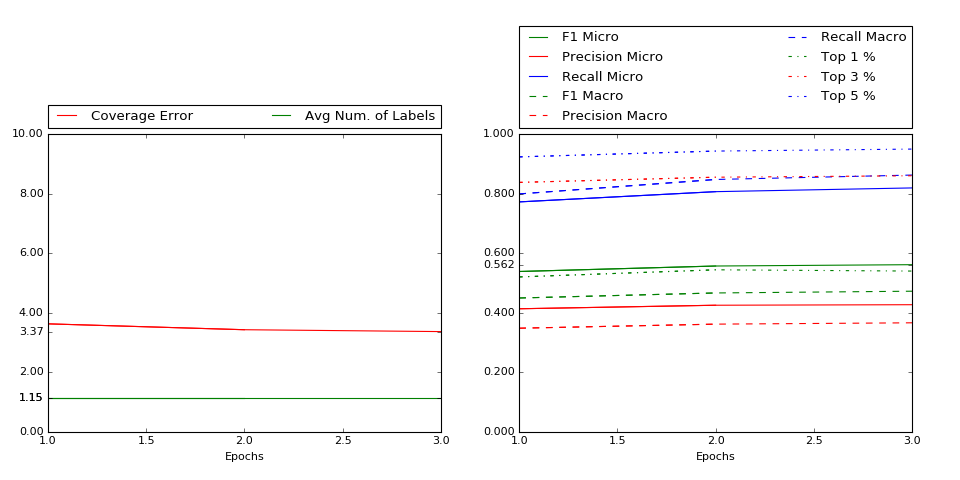

2017-01-20 20:18:46,752 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-20 20:18:46,761 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-01-20 20:19:07,886 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-01-20 20:19:07,897 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-20 20:19:11,000 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_sea

[[0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 1 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.634, Avg Labels: 1.150, 
		 Top 1: 0.521, Top 3: 0.839, Top 5: 0.924, 
		 F1 Micro: 0.539, F1 Macro: 0.450, Total Pos: 689,413


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))
2017-01-20 20:44:53,611 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-01-20 20:44:53,613 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model
2017-01-20 20:45:18,499 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.* with mmap=None
2017-01-20 20:45:18,502 : INFO : loading doctag_syn0 from /mnt/d

[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.437, Avg Labels: 1.150, 
		 Top 1: 0.545, Top 3: 0.856, Top 5: 0.944, 
		 F1 Micro: 0.558, F1 Macro: 0.467, Total Pos: 700,050


2017-01-20 21:10:57,231 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-01-20 21:10:57,232 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model
2017-01-20 21:11:16,975 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.* with mmap=None
2017-01-20 21:11:16,986 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-20 21:11:19,050 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_sea

[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 1 ..., 0 0 0]]


2017-01-20 21:34:40,248 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-01-20 21:34:40,249 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model


** Validation Metrics: Cov Err: 3.374, Avg Labels: 1.150, 
		 Top 1: 0.541, Top 3: 0.861, Top 5: 0.951, 
		 F1 Micro: 0.562, F1 Macro: 0.473, Total Pos: 707,978


In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        break
        
    info('Getting training Data')
    X, y = get_training_data(doc2vec_model, classifications)
    
    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    # try warm start and evaluate after every iter
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER)):
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'w'))
    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'r'))
    
#     # Training Metrics
#     info('Evaluating on Training Data')
#     yp = clf.predict(X)
#     yp_score = clf.decision_function(X)
#     print yp
#     training_metrics = get_metrics(y, yp, yp)
#     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
#         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
#         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
#         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])
    
#     epoch_training_metrics.append(training_metrics)
    
    del X,y
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


In [36]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(6)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2017-01-07 08:32:48,888 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-07 08:32:48,891 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model
2017-01-07 08:33:14,046 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-01-07 08:33:14,048 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-07 08:33:21,936 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_mode

In [35]:
%%time
ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
%time word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-07 08:05:32,383 : INFO : saving Doc2Vec object under /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model, separately None
2017-01-07 08:05:32,384 : INFO : storing numpy array 'doctag_syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy
2017-01-07 08:06:07,546 : INFO : storing numpy array 'syn1neg' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn1neg.npy
2017-01-07 08:06:22,413 : INFO : not storing attribute syn0norm
2017-01-07 08:06:22,414 : INFO : storing numpy array 'syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn

CPU times: user 3h 47min 44s, sys: 4h 31min 2s, total: 8h 18min 46s
Wall time: 21min 14s
CPU times: user 3h 48min 38s, sys: 4h 31min 12s, total: 8h 19min 51s
Wall time: 23min 18s


In [75]:
from multiprocessing.dummy import Pool as ThreadPool 

In [43]:
import thesis.utils.metrics

In [84]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
i=0
doc_contents = []
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    doc_contents.append((doc_id, doc_contents_array))
    if i > 100:
        break

2016-12-28 22:22:21,536 : INFO : Loading new batch
2016-12-28 22:22:27,109 : INFO : Finished loading new batch


In [133]:
def infer_one_doc(doc):
    #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
    rep = doc2vec_model.infer_vector(doc[1])
    return (doc[0], rep)

Threaded Version

In [114]:
%%time
pool = ThreadPool(16)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
threaded_reps = pool.map(infer_one_doc, doc_contents)


CPU times: user 1min 41s, sys: 620 ms, total: 1min 41s
Wall time: 9.83 s


Non-Threaded Version

In [112]:
%%time
reps = []
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
for doc in doc_contents:
    reps.append((doc[0], doc2vec_model.infer_vector(doc[1])))

CPU times: user 14 s, sys: 44 ms, total: 14.1 s
Wall time: 13.9 s


In [100]:
np.array_equal([d[0] for d in reps], [d[0] for d in threaded_reps])

True

More advanced threading

In [140]:
def nothing_func(doc):
    1 + 1

In [139]:
len(validation_docs_list)

12412

In [138]:
len(threaded_reps)

13000

In [ ]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(20)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = []
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(validation_docs_iterator, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        threaded_reps.extend(threaded_reps_partial)
    else:
        break

In [126]:
def g():
    for el in xrange(50):
        yield el

go = g()
result = []
N = 10
for i in itertools.islice(go, N):
    print i

0
1
2
3
4
5
6
7
8
9


In [196]:
X, y = get_training_data(doc2vec_model, classifications)

In [202]:
yc = np.array(y)

In [203]:
yc.shape

(49789, 8)

In [ ]:
from sklearn.svm import SVC

In [219]:
clf = OneVsRestClassifier(estimator=linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                         #alpha is the 1/C parameter
                                                         alpha=0.001, fit_intercept=True, n_iter=10,
                                                         #n_jobs=-1 means use all cpus
                                                         shuffle=True, verbose=1, epsilon=0.1, n_jobs=-1,
                                                         #eta0 is the learning rate when we use constant configuration
                                                         random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                         class_weight=None, warm_start=False), n_jobs=1)

# clf = OneVsRestClassifier(estimator=SVC(kernel='linear'), n_jobs=-1)

In [222]:
yp = clf.predict(X)

print yp

training_metrics = get_metrics(np.array(y), yp, yp)

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 1]]


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predic

In [173]:
import numpy as np
from sklearn import linear_model
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array(['a', 'a', 'b', 'b'])
clf = linear_model.SGDClassifier()
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [ ]:
clf.predict([[-0.8, -1]])

In [26]:
best_svm_epoch = 13

In [29]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(best_svm_epoch)
doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2016-11-26 18:25:14,192 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model
2016-11-26 18:25:14,584 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.* with mmap=None
2016-11-26 18:25:14,585 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.doctag_syn0.npy with mmap=None
2016-11-26 18:25:14,814 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.syn1neg.npy with mmap

#### Prepare Training Data

In [31]:
%%time
classifications = sections

NN_OUTPUT_NEURONS = len(classifications)
one_hot_encoder = OneHotEncoder(classifications)
training_data = []
training_labels = []
for doc_id in training_docs_list:
    # converting from memmap to a normal array
    normal_array = []
    normal_array[:] = doc2vec_model.docvecs[doc_id][:]
    training_data.append(normal_array)
    eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
    training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

CPU times: user 1.61 s, sys: 520 ms, total: 2.13 s
Wall time: 1.93 s


#### Prepare Validation Data

In [32]:
%%time

validation_labels = []
validation_data = pickle.load(open(
        os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)
))
print validation_data.shape

for validation_doc_id in validation_docs_list:
    eligible_classifications = [clssf for clssf in doc_classification_map[validation_doc_id] if clssf in classifications]
    validation_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

(1969, 3000)
CPU times: user 2.58 s, sys: 360 ms, total: 2.94 s
Wall time: 2.93 s


#### Create Keras NN

In [173]:
import itertools
from keras.layers import Dropout

In [186]:
pickle.dump(history_list, open('/mnt/data2/shalaby/history_list_sample_0.0001.pickle','w'))

In [181]:
print len(history_list)

100


In [147]:
doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
hidden = Dense(NN_HIDDEN_NEURONS, activation='relu', name='hidden_layer')(doc_input)
softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
model = Model(input=doc_input, output=softmax_output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'fbeta_score', theano_coverage_error])

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer (Dense)             (None, 4500)          13504500    doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             36008       hidden_layer[0][0]               
Total params: 13540508
____________________________________________________________________________________________________


In [162]:
model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=1, verbose=1)

Train on 8979 samples, validate on 1969 samples
Epoch 1/1
8979/8979 [==============================] - 4s - loss: 0.0427 - acc: 0.9835 - fbeta_score: 0.9504 - coverage error: 1.4936 - val_loss: 2.1309 - val_acc: 0.8531 - val_fbeta_score: 0.4738 - val_coverage error: 3.4474


In [143]:
val_prediction = model.predict(validation_data)

In [144]:
val_prediction[:2]

array([[  2.70263344e-01,   3.49998474e-02,   3.13610617e-05,
          1.08150870e-03,   3.11665332e-07,   7.09001958e-01,
          4.97711152e-02,   2.63609409e-01],
       [  1.70166213e-02,   5.36046147e-01,   2.61311390e-04,
          4.87348643e-06,   1.27638310e-01,   9.57404263e-03,
          3.39831635e-02,   2.13784515e-03]], dtype=float32)